# setup

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import warnings
import nutpie
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import seaborn as sns
import pickle
import matplotlib.patches as patches

In [2]:
az.style.use("arviz-white") #arviz-darkgrid
RANDOM_SEED = 123
warnings.filterwarnings("ignore")

In [3]:
with open('dataTable_2T.pkl', 'rb') as f:
    dataTable_2T = pickle.load(f)

In [4]:
# choose if you want to save all data for statistical analysis
SaveAllData = True  # True False

# load table

In [5]:
behaviorTable = pd.read_csv('D:/code/lab/csv tables/behaviorTableExp2.csv') 
episodeTable = pd.read_csv('D:/code/lab/csv tables/episodeTableExp2.csv')
subjectTable = pd.read_csv('D:/code/lab/csv tables/subjectTableExp2.csv')

In [6]:
episodeTable.loc[episodeTable['trialNumEp'].between(139, 150), 'episode'] = 300

In [7]:
numS = subjectTable.shape[0]
numTrials = behaviorTable['trialNum'].max()
allGroups = subjectTable['delay'].unique()
numGroups = len(allGroups)
subjPerGroup = subjectTable.groupby('delay').size().values

numData = behaviorTable.shape[0]
bNans = np.nan * np.ones(numData)
behaviorTable['sIndex'] = bNans
behaviorTable['gp'] = bNans
behaviorTable['epIndex'] = bNans

for groupN in range(numData):
    sID = behaviorTable['subject'][groupN]
    t = behaviorTable['trialNum'][groupN]
    thisS = np.where(subjectTable['subjectST'] == sID)[0]
    if len(thisS) != 1:
        raise ValueError('No subject or more than one subject found')
        
    sIndex = subjectTable['subjectST'].values[thisS][0]-1
    gp = subjectTable['delay'].values[thisS][0]-1
    thisEp = np.where((episodeTable['trialNumEp'].values == t) & (episodeTable['groupIDEp'].values == gp+1))[0]

    if len(thisEp) != 1:
        raise ValueError('No episode or more than one episode found')

    allEpisodes, _, epIdx = np.unique(episodeTable['episode'], return_inverse=True, return_index=True)
    episodeTable['epIndex'] = epIdx
    epIndex = episodeTable['epIndex'][thisEp]
    
    behaviorTable.at[groupN, 'sIndex'] = sIndex
    behaviorTable.at[groupN, 'gp'] = gp
    behaviorTable.at[groupN, 'epIndex'] = epIndex

In [8]:
allTable = pd.merge(behaviorTable, dataTable_2T, on=['errorCorrect','subject', 'trialNum']).drop(columns=['delay'])

In [9]:
allTable

,errorCorrect,subject,trialNum,sIndex,gp,epIndex,eyeError,subj_id,reactionTime
0,-1.704100,1,1,0.0,0.0,0.0,16.945032,129,0.790041
1,4.743692,1,2,0.0,0.0,0.0,9.849141,129,0.952798
2,2.322730,1,3,0.0,0.0,0.0,1.783923,129,0.850252
3,-2.492491,1,4,0.0,0.0,0.0,10.160414,129,0.849789
4,-8.660361,1,5,0.0,0.0,0.0,9.768107,129,1.468026
...,...,...,...,...,...,...,...,...,...
5545,9.060991,37,146,36.0,0.0,83.0,0.388128,261,0.616929
5546,-2.978255,37,147,36.0,0.0,83.0,10.377917,261,0.623493
5547,14.683094,37,148,36.0,0.0,83.0,11.345418,261,0.726939
5548,5.928922,37,149,36.0,0.0,83.0,-9.209364,261,0.534230


# model

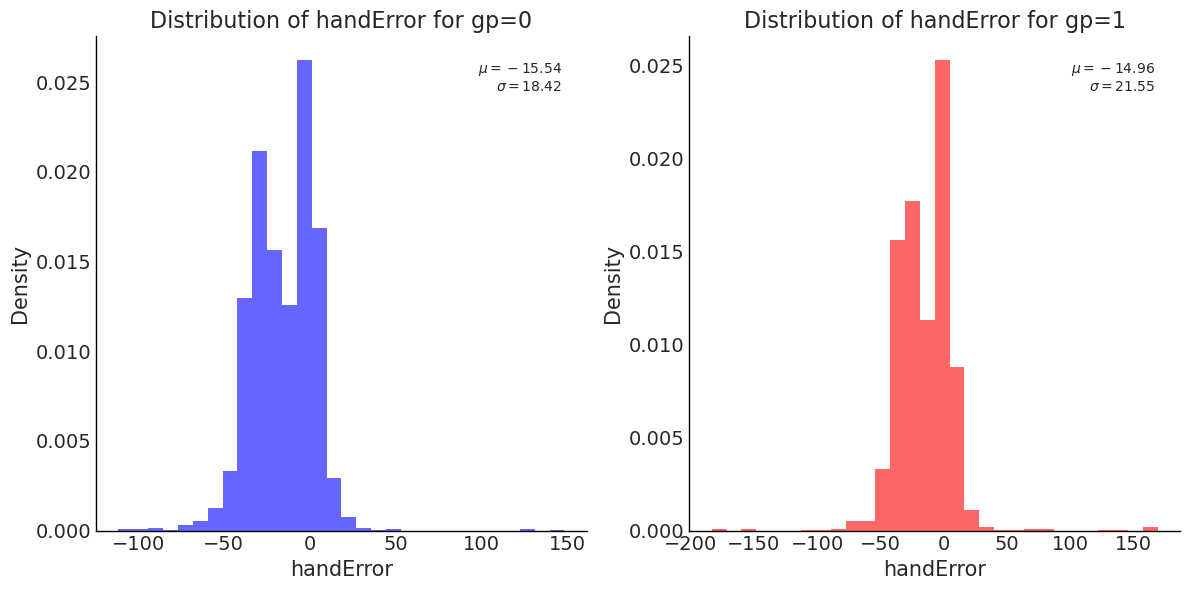

In [10]:
# plot distribution
# 绘制 gp=0 和 gp=1 的 handError 分布
plt.figure(figsize=(12, 6))

# 创建两个子图
plt.subplot(1, 2, 1)
gp0_hand_errors = allTable[allTable['gp'] == 0]['errorCorrect']
mu_gp0 = np.mean(gp0_hand_errors)
sigma_gp0 = np.std(gp0_hand_errors)
plt.hist(gp0_hand_errors, bins=30, density=True, alpha=0.6, color='b')
plt.title('Distribution of handError for gp=0')
plt.xlabel('handError')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp0:.2f}$\n$\sigma={sigma_gp0:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.subplot(1, 2, 2)
gp1_hand_errors = allTable[allTable['gp'] == 1]['errorCorrect']
mu_gp1 = np.mean(gp1_hand_errors)
sigma_gp1 = np.std(gp1_hand_errors)
plt.hist(gp1_hand_errors, bins=30, density=True, alpha=0.6, color='r')
plt.title('Distribution of handError for gp=1')
plt.xlabel('handError')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp1:.2f}$\n$\sigma={sigma_gp1:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

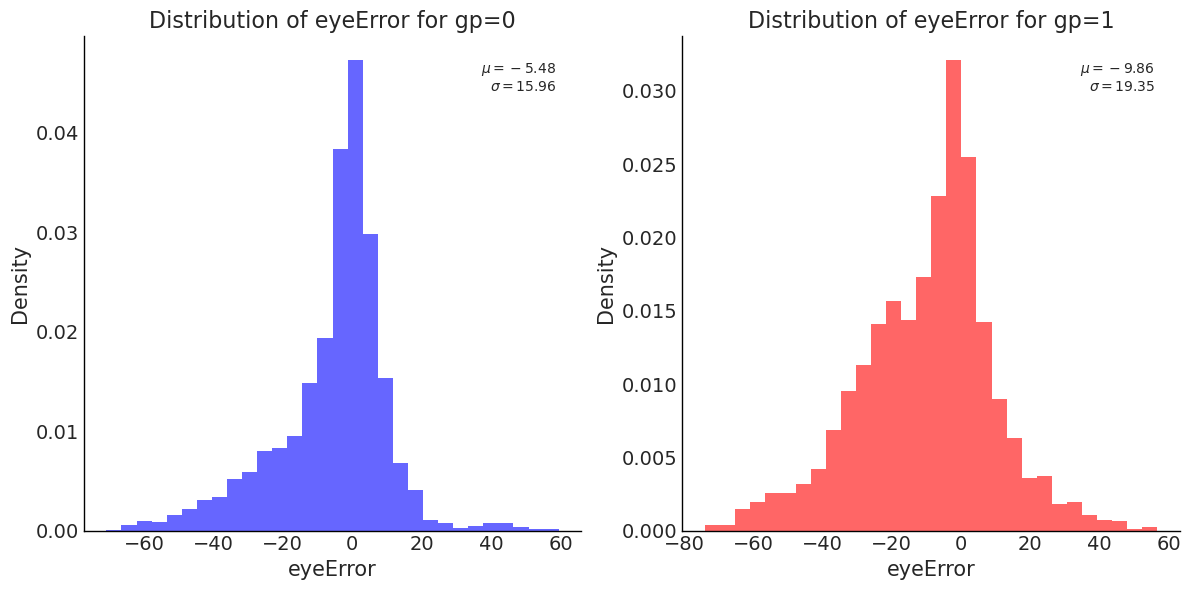

In [11]:
# 绘制 gp=0 和 gp=1 的 eyeError 分布
plt.figure(figsize=(12, 6))

# 创建两个子图
plt.subplot(1, 2, 1)
gp0_eye_errors = allTable[allTable['gp'] == 0]['eyeError']
mu_gp0 = np.mean(gp0_eye_errors)
sigma_gp0 = np.std(gp0_eye_errors)
plt.hist(gp0_eye_errors, bins=30, density=True, alpha=0.6, color='b')
plt.title('Distribution of eyeError for gp=0')
plt.xlabel('eyeError')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp0:.2f}$\n$\sigma={sigma_gp0:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.subplot(1, 2, 2)
gp1_eye_errors = allTable[allTable['gp'] == 1]['eyeError']
mu_gp1 = np.mean(gp1_eye_errors)
sigma_gp1 = np.std(gp1_eye_errors)
plt.hist(gp1_eye_errors, bins=30, density=True, alpha=0.6, color='r')
plt.title('Distribution of eyeError for gp=1')
plt.xlabel('eyeError')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp1:.2f}$\n$\sigma={sigma_gp1:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()


In [12]:
var_names=['a0','aD','aE','aS']  #,'aES','aED'

numGroups = len(np.unique(allTable['gp']))
numS = len(np.unique(allTable['sIndex']))
numEps = len(np.unique(allTable['epIndex']))

## Hand

In [13]:
y = allTable.errorCorrect.values # hand error
e = allTable.epIndex.values.astype(int) # episode
d = allTable.gp.values.astype(int) # group
s = allTable.sIndex.values.astype(int) # subject

# find NaN and interpret
nan_indices = np.isnan(y)
interp_func = np.interp(nan_indices.nonzero()[0], (~nan_indices).nonzero()[0], y[~nan_indices])
y[nan_indices] = interp_func
# check NaN
#has_nan = np.any(np.isnan(y))
#print(has_nan)

In [14]:
# 定义 gamma 分布的 shape(alpha) 和 rate(beta) 参数
def gam_ra(m, v):
    return (m + np.sqrt(m**2 + 4*v)) / (2*v)

def gam_sh(m, v):
    return 1 + m * gam_ra(m, v)

In [15]:
### priors

# A0 should distribute reasonably close to the mean of the data. There's a 
# a lot of data, but also a lot of model degrees of freedom, we'll just
# give it a variance equal to 10 times the standard SEM since that seems like 
# a lot of uncertainty.
muA0 = np.nanmean(y)
sdA0 = 10*np.nanstd(y)/np.sqrt(numData)

# sdAD must be smaller than std(y) and is probably around the SEM for each
#  group. The average amount of data in a group will be numData / numDurations,
#  so we could use that to get an SEM. Let's multiply by 10 again as a large
#  uncertainty.
sdAD = 10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)/2 #np.nanstd(y)*2

#  estimating sdAE the same way as sdAD so we're starting with a large
# uncertainty but smaller than std(y)
sdAE = 10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)/2 #np.nanstd(y)*2


# sdY的gamma 分布的 mode 和 sd
mode_sdY = 20
sd_sdY = 10
sh_sdY = gam_sh(mode_sdY, sd_sdY)
ra_sdY = gam_ra(mode_sdY, sd_sdY)

# sdAS的gamma 分布的 mode 和 sd
#  sdAS is the difference between subject means. This complements modeModeSdY
#  which is the average within subject noise.
#  We can use the same logic here that we did with sdAD: the between subject
#  noise is probably around the SEM across subjects:
mode_sdAS = 10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)*2
sd_sdAS =  10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)*2
sh_sdAS = gam_sh(mode_sdAS, sd_sdAS)
ra_sdAS = gam_ra(mode_sdAS, sd_sdAS)

# sdAED的gamma 分布的 mode 和 sd
# sdED (episode by group interaction) is hierarchically sampled. We'll take them with a mode that is 1/4 of the mode of sdY and,
#  again, a width 10 times the mode.
mode_sdAED = 10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)*2
sd_sdAED = 10*np.nanstd(y)/np.sqrt(numData) #np.nanstd(y)*2
sh_sdAED = gam_sh(mode_sdAED, sd_sdAED)
ra_sdAED = gam_ra(mode_sdAED, sd_sdAED)

In [16]:
with pm.Model(coords = {
    'subjects': range(numS),
    'groups': range(numGroups),
    'episodes': range(numEps)
}) as model1:
    # Hyper priors
    sdAS = pm.Gamma('sdAS', alpha=sh_sdAS, beta=ra_sdAS)
    sdAED = pm.Gamma('sdAED', alpha=sh_sdAED, beta=ra_sdAED)
#     nu = pm.Exponential('nu',lam=5)
    # Priors
    aED = pm.Normal("aED", mu=0, sigma=sdAED, dims=('episodes', 'groups'))
#     aED = pm.StudentT("aED", nu=nu, mu=0, sigma=sdAED, dims=('episodes', 'groups'))
    
    aS = pm.Normal('aS', mu=0, sigma=sdAS, dims='subjects')   
    aES = pm.Normal('aES', mu=0, sigma=sdAS, dims=('episodes', 'subjects'))  
    
    a0 = pm.Normal('a0', mu=muA0, sigma=sdA0)   
    aE = pm.Normal('aE', mu=0, sigma=sdAE, dims='episodes')   
    aD = pm.Normal('aD', mu=0, sigma=sdAD, dims='groups')   
    
#     sdY = pm.Gamma('sdY', alpha=sh_sdY, beta=ra_sdY, dims='subjects')
    sdY = pm.HalfNormal('sdY', sigma=mode_sdY, dims='subjects')
    
    muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]

#     y_obs = pm.StudentT('y_obs', nu=nu, mu=muY, sigma=sdY[s], observed=y)
    y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y)

In [17]:
# with pm.Model(coords = {
#     'subjects': range(numS),
#     'groups': range(numGroups),
#     'episodes': range(numEps)
# }) as model1:
#     # Hyper priors
#     sdAS = pm.Gamma('sdAS', mu=2, sigma=10)
    
#     # Priors
#     a0 = pm.Normal('a0', mu=muA0, sigma=sdA0)
#     aE = pm.Normal('aE', mu=0, sigma=10, dims='episodes')
#     aD = pm.Normal('aD', mu=0, sigma=10, dims='groups')
#     aS = pm.Normal('aS', mu=0, sigma=sdAS, dims='subjects')
#     aED = pm.Normal('aED', mu=0, sigma=5, dims=('episodes', 'groups')) 
#     aES = pm.Normal('aES', mu=0, sigma=sdAS, dims=('episodes', 'subjects')) 
    
#     sdY = pm.HalfNormal('sdY', sigma=8, dims='subjects')
    
#     muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]

#     y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y)

Sampling: [a0, aD, aE, aED, aES, aS, sdAED, sdAS, sdY, y_obs]


<Axes: xlabel='y_obs / y_obs'>

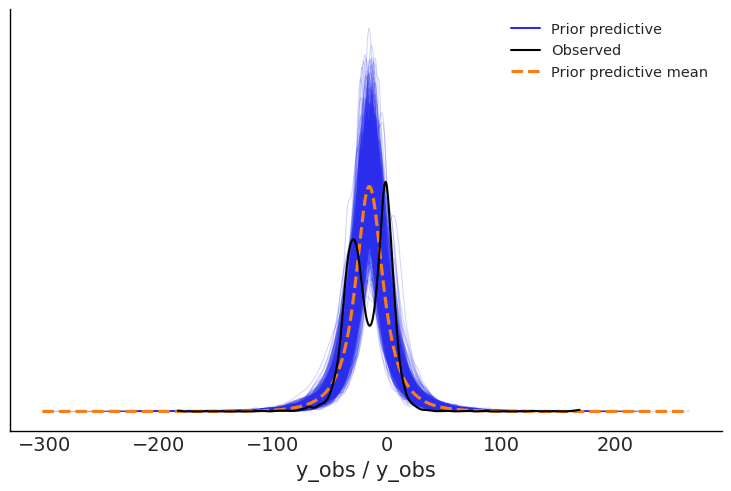

In [18]:
prior_checks1 = pm.sample_prior_predictive(samples=1000, model=model1)
az.plot_ppc(prior_checks1, observed=True, group="prior")

In [19]:
compiled_model1 = nutpie.compile_pymc_model(model1)

In [20]:
trace1 = nutpie.sample(compiled_model1, draws=1000, tune=1000, chains=4, target_accept=0.95)

In [21]:
# trace1 = pm.sample(1000, tune=1000, target_accept=0.95, nuts={"max_treedepth": 20}, random_seed=RANDOM_SEED, model=model1)

In [22]:
# ppc1 = pm.sample_posterior_predictive(trace1, model=model1)
# az.plot_ppc(ppc1, mean=True)

In [23]:
az.summary(trace1, round_to=2, var_names=var_names, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a0,-21.73,1.73,-25.19,-18.44,0.14,0.10,159.17,361.09,1.01
aD[0],-3.01,1.97,-6.66,1.19,0.18,0.13,121.93,275.93,1.01
aD[1],-3.31,1.84,-7.01,0.30,0.14,0.10,169.45,397.46,1.03
aE[0],8.62,2.49,3.81,13.41,0.17,0.12,211.42,614.57,1.01
aE[1],8.51,2.39,4.07,13.33,0.15,0.11,250.80,646.17,1.01
...,...,...,...,...,...,...,...,...,...
aS[32],-1.80,2.00,-5.82,2.00,0.14,0.10,207.13,317.67,1.02
aS[33],4.58,2.03,0.59,8.51,0.15,0.10,195.51,271.96,1.02
aS[34],-2.33,2.00,-6.13,1.60,0.16,0.12,149.21,632.35,1.02
aS[35],-0.94,2.03,-5.01,2.98,0.14,0.10,229.98,286.22,1.02


## Eye

In [24]:
y_eye = allTable.eyeError.values # eye error  111111111111111111111111111111111111111111111111111111
e = allTable.epIndex.values.astype(int) # epis
d = allTable.gp.values.astype(int) # group
s = allTable.sIndex.values.astype(int) # subject

# find NaN and interpret
nan_indices = np.isnan(y_eye)
interp_func = np.interp(nan_indices.nonzero()[0], (~nan_indices).nonzero()[0], y_eye[~nan_indices])
y_eye[nan_indices] = interp_func
# check
# has_nan = np.any(np.isnan(y))
# print(has_nan)

In [25]:
# 定义 gamma 分布的 shape(alpha) 和 rate(beta) 参数
def gam_ra(m, v):
    return (m + np.sqrt(m**2 + 4*v)) / (2*v)

def gam_sh(m, v):
    return 1 + m * gam_ra(m, v)

In [26]:
### priors

# A0 should distribute reasonably close to the mean of the data. There's a 
# a lot of data, but also a lot of model degrees of freedom, we'll just
# give it a variance equal to 10 times the standard SEM since that seems like 
# a lot of uncertainty.
muA0 = np.nanmean(y_eye)
sdA0 = 10*np.nanstd(y_eye)/np.sqrt(numData)

# sdAD must be smaller than std(y) and is probably around the SEM for each
#  group. The average amount of data in a group will be numData / numDurations,
#  so we could use that to get an SEM. Let's multiply by 10 again as a large
#  uncertainty.
sdAD = np.nanstd(y_eye)*2 #10*np.nanstd(y_eye)/np.sqrt(numData) #np.nanstd(y_eye)*2

#  estimating sdAE the same way as sdAD so we're starting with a large
# uncertainty but smaller than std(y)
sdAE = np.nanstd(y_eye)*1.5 #np.nanstd(y_eye)*2


# sdY的gamma 分布的 mode 和 sd
mode_sdY = 10
sd_sdY = 10
sh_sdY = gam_sh(mode_sdY, sd_sdY)
ra_sdY = gam_ra(mode_sdY, sd_sdY)

# sdAS的gamma 分布的 mode 和 sd
#  sdAS is the difference between subject means. This complements modeModeSdY
#  which is the average within subject noise.
#  We can use the same logic here that we did with sdAD: the between subject
#  noise is probably around the SEM across subjects:
mode_sdAS = 10*np.nanstd(y_eye)/np.sqrt(numData) #np.nanstd(y)*2
sd_sdAS =  np.nanstd(y_eye)/2 #np.nanstd(y)*2
sh_sdAS = gam_sh(mode_sdAS, sd_sdAS)
ra_sdAS = gam_ra(mode_sdAS, sd_sdAS)

# sdAED的gamma 分布的 mode 和 sd
# sdED (episode by group interaction) is hierarchically sampled. We'll take them with a mode that is 1/4 of the mode of sdY and,
#  again, a width 10 times the mode.
mode_sdAED = 10*np.nanstd(y_eye)/np.sqrt(numData) #np.nanstd(y)*2
sd_sdAED = np.nanstd(y_eye) #np.nanstd(y)*2
sh_sdAED = gam_sh(mode_sdAED, sd_sdAED)
ra_sdAED = gam_ra(mode_sdAED, sd_sdAED)

In [27]:
print('muA0:', muA0)
print('sdA0:', sdA0)
print('sdAD:', sdAD)
print('sdAE:', sdAE)
print('sh_sdY:', sh_sdY)
print('ra_sdY:', ra_sdY)
print('mode_sdAS:', mode_sdAS)
print('sd_sdAS:', sd_sdAS)
print('sh_sdAS:', sh_sdAS)
print('ra_sdAS:', ra_sdAS)
print('mode_sdAED:', mode_sdAED)
print('sd_sdAED:', sd_sdAED)
print('sh_sdAED:', sh_sdAED)
print('ra_sdAED:', ra_sdAED)

muA0: -7.657795450169093
sdA0: 2.411940909559139
sdAD: 35.937110167172634
sdAE: 26.952832625379475
sh_sdY: 11.916079783099615
ra_sdY: 1.0916079783099615
mode_sdAS: 2.411940909559139
sd_sdAS: 8.984277541793158
sh_sdAS: 2.191129975411359
ra_sdAS: 0.49384708003857225
mode_sdAED: 2.411940909559139
sd_sdAED: 17.968555083586317
sh_sdAED: 1.7534551751193088
ra_sdAED: 0.312385420444246


In [28]:
with pm.Model(coords = {
    'subjects': range(numS),
    'groups': range(numGroups),
    'episodes': range(numEps)
}) as model2:
    # Hyper priors
    sdAS = pm.Gamma('sdAS', mu=2, sigma=8)
    sdAED = pm.Gamma('sdAED', mu=10, sigma=8)

    # Priors
    aED = pm.Normal("aED", mu=0, sigma=sdAED, dims=('episodes', 'groups'))
    
    aS = pm.Normal('aS', mu=0, sigma=sdAS, dims='subjects')   
    aES = pm.Normal('aES', mu=0, sigma=sdAS, dims=('episodes', 'subjects'))  
    
    a0 = pm.Normal('a0', mu=muA0, sigma=sdA0)   
    aE = pm.Normal('aE', mu=0, sigma=sdAE, dims='episodes')   
    aD = pm.Normal('aD', mu=0, sigma=sdAD, dims='groups')   
    
    sdY = pm.HalfNormal('sdY', sigma=mode_sdY, dims='subjects')
    
    muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]

#     y_obs = pm.StudentT('y_obs', nu=nu, mu=muY, sigma=sdY[s], observed=y_eye)
    y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y_eye)

In [29]:
# with pm.Model(coords = {
#     'subjects': range(numS),
#     'groups': range(numGroups),
#     'episodes': range(numEps)
# }) as model2:
#     # Hyper priors
#     sdAS = pm.Gamma('sdAS', mu=2, sigma=8)
#     nu = pm.Exponential('nu',lam=0.1) 
#     a0 = pm.Normal('a0', mu=muA0, sigma=sdA0)   
#     aE = pm.Normal('aE', mu=0, sigma=20, dims='episodes')   
#     aD = pm.Normal('aD', mu=10, sigma=25, dims='groups')   
#     aS = pm.Normal('aS', mu=0, sigma=10, dims='subjects')   
#     aED = pm.Normal('aED', mu=0, sigma=10, dims=('episodes', 'groups'))   
#     aES = pm.Normal('aES', mu=0, sigma=sdAS, dims=('episodes', 'subjects'))    
#     sdY = pm.HalfNormal('sdY', sigma=10, dims='subjects')
    
#     muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]

#     y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y_eye)
# #     y_obs = pm.StudentT('y_obs', nu=nu, mu=muY, sigma=sdY[s], observed=y_eye)

Sampling: [a0, aD, aE, aED, aES, aS, sdAED, sdAS, sdY, y_obs]


<Axes: xlabel='y_obs / y_obs'>

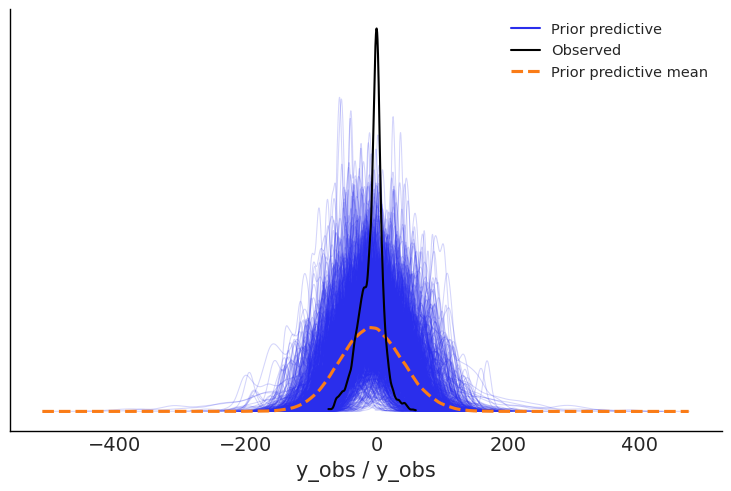

In [30]:
prior_checks2 = pm.sample_prior_predictive(samples=1000, model=model2)
az.plot_ppc(prior_checks2, observed=True, group="prior")

In [31]:
compiled_model2 = nutpie.compile_pymc_model(model2) 

In [32]:
trace2 = nutpie.sample(compiled_model2, draws=1000, tune=1000, chains=4, target_accept=0.98) 

In [33]:
# trace2 = pm.sample(1000, tune=1000, target_accept=0.98, nuts={"max_treedepth": 20}, random_seed=RANDOM_SEED, model=model2)

array([[<Axes: title={'center': 'a0'}>, <Axes: title={'center': 'a0'}>],
       [<Axes: title={'center': 'aD'}>, <Axes: title={'center': 'aD'}>]],
      dtype=object)

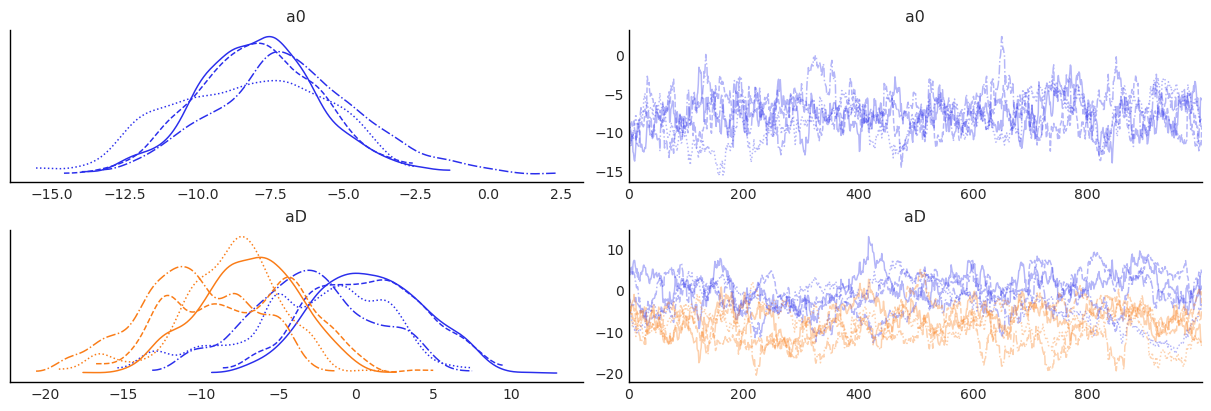

In [34]:
az.plot_trace(trace2,var_names=['a0', 'aD'])

In [35]:
# ppc2 = pm.sample_posterior_predictive(trace2, model=model2)
# az.plot_ppc(ppc2, mean=True)

In [36]:
az.summary(trace2, round_to=2, var_names=['a0','aD','aE','aS'],hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a0,-7.74,2.43,-12.45,-3.19,0.36,0.26,44.13,116.96,1.09
aD[0],-1.05,4.47,-10.46,7.23,1.29,0.94,12.01,34.58,1.24
aD[1],-8.21,3.99,-16.82,-1.28,0.96,0.69,17.25,140.29,1.18
aE[0],12.49,3.21,6.09,18.81,0.74,0.53,18.93,53.81,1.16
aE[1],12.74,3.45,6.21,19.84,0.86,0.62,16.16,107.33,1.17
...,...,...,...,...,...,...,...,...,...
aS[32],-4.25,2.88,-10.23,0.83,0.34,0.31,70.79,105.78,1.04
aS[33],-6.36,2.80,-11.90,-1.25,0.37,0.31,57.60,119.31,1.06
aS[34],3.78,2.96,-2.19,9.45,0.34,0.24,73.56,195.51,1.06
aS[35],2.29,2.84,-3.38,7.60,0.32,0.23,79.62,185.83,1.05


# calculations

In [37]:
numChains = 4
numSamples = 1000
subjPerGroup = np.bincount(subjectTable['delay']-1)

# extract and define all episodes from samples
earlyBaseEps = [1]
epIndexesEarlyBase = np.where(np.isin(allEpisodes, earlyBaseEps))[0]
numEarlyBaseEps = len(earlyBaseEps)
earlyBaseSamplesEp = np.zeros((numChains * numSamples, numEarlyBaseEps))

lateBaseEps = [2]
epIndexesLateBase = np.where(np.isin(allEpisodes, lateBaseEps))[0]
numLateBaseEps = len(lateBaseEps)
lateBaseSamplesEp = np.zeros((numChains * numSamples, numLateBaseEps))

adaptEps = np.arange(100, 180)
epIndexesAdapt = np.where(np.isin(allEpisodes, adaptEps))[0]
numAdaptEps = len(adaptEps)
adaptSamplesEp = np.zeros((numChains * numSamples, numAdaptEps))

implicitEps = [200]
epIndexesImplicit = np.where(np.isin(allEpisodes, implicitEps))[0]
numImplicitEps = len(implicitEps)
implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))

afterEps = [300]
epIndexesAfter = np.where(np.isin(allEpisodes, afterEps))[0]
numAfterEps = len(afterEps)
afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))

## hand

In [38]:
# initialize
earlyBaseMeansAll = np.full((numGroups, 1), np.nan)
earlyBaseHDIAll = [None] * numGroups
lateBaseMeansAll = np.full((numGroups, 1), np.nan)
lateBaseHDIAll = [None] * numGroups

implicitMeansAll = np.full((numGroups, 1), np.nan)
implicitHDIAll = [None] * numGroups
implicitHDI = np.full((numGroups, 2), np.nan)
implicitSamples = [None] * numGroups

afterMeansAll = np.full((numGroups, 1), np.nan)
afterHDIAll = [None] * numGroups
afterHDI = np.full((numGroups, 2), np.nan)
afterSamples = [None] * numGroups

adaptMeansAll = [None] * numGroups
adaptHDIAll = [None] * numGroups
adaptHDI = np.zeros((numGroups, numAdaptEps, 2))
adaptSubjSamples = [[] for _ in range(numGroups)]
adaptSubjHDI = [[] for _ in range(numGroups)]

earlyBaseHDI = np.full((numGroups, 2), np.nan)
lateBaseHDI = np.full((numGroups, 2), np.nan)

earlyBaseSubjMeans = [[] for _ in range(numGroups)]
earlyBaseSubjHDI = [[] for _ in range(numGroups)]
lateBaseSubjMeans = [[] for _ in range(numGroups)]
lateBaseSubjHDI = [[] for _ in range(numGroups)]

lastAdaptSubjMeans = [[] for _ in range(numGroups)]
lastAdaptSubjHDI = [[] for _ in range(numGroups)]
lastAdaptSubjSamples = [[] for _ in range(numGroups)]

implicitSubjMeans = [[] for _ in range(numGroups)]
implicitSubjHDI = [[] for _ in range(numGroups)]
implicitSubjSamples = [[] for _ in range(numGroups)]

afterSubjMeans = [[] for _ in range(numGroups)]
afterSubjHDI = [[] for _ in range(numGroups)]
afterSubjSamples = [[] for _ in range(numGroups)]

mEpGpS = [None] * numGroups
mS = [None] * numGroups
mGp = np.zeros((numChains, numSamples, numGroups))
mEpGp = np.zeros((numChains, numSamples, numEps, numGroups))

In [39]:
b0 = trace1.posterior['a0']
bD = trace1.posterior['aD']
bS = trace1.posterior['aS']
bE = trace1.posterior['aE']
bED = trace1.posterior['aED']
bES = trace1.posterior['aES']

In [40]:
for gpNum in range(1,numGroups+1):
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    thisNumS = theseS.shape[0]
    mEpGpS[gpNum - 1] = np.zeros((numChains, numSamples, numEps, thisNumS))
    mS[gpNum - 1] = np.zeros((numChains, numSamples, thisNumS))
    
    for epNum in range(1,numEps+1):      
        for sNum in range(1,subjPerGroup[gpNum-1]+1):
            sIndex = theseS.loc[theseS.index == sNum-1, 'subjectST'].values[0]
            mEpGpS[gpNum-1][:,:,epNum-1, sNum-1] = (
                b0 + 
                bE[:, :, epNum-1] + 
                bD[:, :, gpNum-1] + 
                bS[:, :, sIndex-1]+ 
                bED[:, :, epNum-1, gpNum-1] + 
                bES[:, :, epNum-1, sIndex-1]
            )
        
        mEpGp[:, :, epNum-1, gpNum-1] = np.nanmean(mEpGpS[gpNum-1][:, :, epNum-1, :], axis=2)
    
    mS[gpNum - 1] = np.reshape(np.nanmean(mEpGpS[gpNum - 1], axis=2), (numChains, numSamples, subjPerGroup[gpNum - 1]))
    mGp[:, :, gpNum-1] = np.mean(mS[gpNum-1], axis=2)

mEp = np.nanmean(mEpGp, axis=3)
m = np.mean(mGp, axis=2)

# Correct for mean shift of groups
b0 = m
bE = mEp - np.tile(m[:, :, np.newaxis], (1, 1, numEps))
bD = mGp - np.tile(m[:, :, np.newaxis], (1, 1, numGroups))
bED = mEpGp - np.tile(mEp[:, :, :, np.newaxis], (1, 1, 1, numGroups))
- np.tile(np.reshape(mGp, (numChains, numSamples, 1, numGroups)), (1, 1, numEps, 1)) 
+ np.tile(m[:, :, np.newaxis, np.newaxis], (1, 1, numEps, numGroups))

for sIndex in range(1,numS+1):
    gpNum = subjectTable.loc[sIndex - 1, 'delay']  # gpNum=1 or 2
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    sNum = theseS.index[theseS['subjectST'] == sIndex][0]
    bS[:, :, sIndex-1] = mS[gpNum-1][:, :, sNum] - mGp[:, :, gpNum-1]
    
    bES[:, :, :, sIndex-1] = (
    mEpGpS[gpNum-1][:, :, :, sNum] - 
    (np.tile(bS.values[:, :, sIndex-1, np.newaxis], (1, 1, numEps)) + mEpGp[:, :, :, gpNum-1])
    )

In [41]:
# Create a dictionary to hold the variables
samples1 = {
    'b0': b0,
    'bD': bD,
    'bS': bS,
    'bE': bE,
    'bED': bED,
    'bES': bES,
    'mAll': m,
    'mSubj': mS,
    'mdelay': mGp,
    'mEp': mEp,
    'mEpGp': mEpGp,
    'mEpGpS': mEpGpS
}

In [42]:
# Getting all the samples for the earlybaseline, latebaseline, implicit, aftereffect
for gpNum in range(numGroups):
    for epNum in range(numEarlyBaseEps):
        theseSamples = (
            samples1['b0'] + samples1['bE'][:, :, epIndexesEarlyBase[epNum]]
            + samples1['bD'][:, :, gpNum] + samples1['bED'][:, :, epIndexesEarlyBase[epNum], gpNum]
        )
        earlyBaseSamplesEp[:, epNum] = theseSamples.flatten()
            
        theseSamples = (
            samples1['b0'] + samples1['bE'][:, :, epIndexesLateBase[epNum]]
            + samples1['bD'][:, :, gpNum] + samples1['bED'][:, :, epIndexesLateBase[epNum], gpNum]
        )
        lateBaseSamplesEp[:, epNum] = theseSamples.flatten()
 
        theseSamples = (
            samples1['b0'] + samples1['bE'][:, :, epIndexesImplicit[epNum]]
            + samples1['bD'][:, :, gpNum] + samples1['bED'][:, :, epIndexesImplicit[epNum], gpNum]
        )
        implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))
        implicitSamplesEp[:, epNum] = theseSamples.flatten()
        
        theseSamples = (
            samples1['b0'] + samples1['bE'][:, :, epIndexesAfter[epNum]]
            + samples1['bD'][:, :, gpNum] + samples1['bED'][:, :, epIndexesAfter[epNum], gpNum]
        )
        afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))
        afterSamplesEp[:, epNum] = theseSamples.flatten()
            
    earlyBaseMeansAll[gpNum] = np.mean(earlyBaseSamplesEp)
    earlyBaseHDIAll[gpNum] = az.hdi(earlyBaseSamplesEp, hdi_prob=0.95)
    lateBaseMeansAll[gpNum] = np.mean(lateBaseSamplesEp)
    lateBaseHDIAll[gpNum] = az.hdi(lateBaseSamplesEp, hdi_prob=0.95)
    implicitMeansAll[gpNum] = np.mean(implicitSamplesEp)
    implicitHDIAll[gpNum] = az.hdi(implicitSamplesEp, hdi_prob=0.95)    
    afterMeansAll[gpNum] = np.mean(afterSamplesEp)
    afterHDIAll[gpNum] = az.hdi(afterSamplesEp, hdi_prob=0.95)
    # Save aftereffect samples so we can calculate differences between groups
    implicitSamples[gpNum] = implicitSamplesEp
    afterSamples[gpNum] = afterSamplesEp
    # HDI for use in errorbar function
    earlyBaseHDI[gpNum, 0] = earlyBaseHDIAll[gpNum][0][0] - earlyBaseMeansAll[gpNum][0]
    earlyBaseHDI[gpNum, 1] = earlyBaseMeansAll[gpNum][0] - earlyBaseHDIAll[gpNum][0][1]
    lateBaseHDI[gpNum, 0] = lateBaseHDIAll[gpNum][0][0] - lateBaseMeansAll[gpNum][0]
    lateBaseHDI[gpNum, 1] = lateBaseMeansAll[gpNum][0] - lateBaseHDIAll[gpNum][0][1]
    implicitHDI[gpNum, 0] = implicitHDIAll[gpNum][0][0] - implicitMeansAll[gpNum][0]
    implicitHDI[gpNum, 1] = implicitMeansAll[gpNum][0] - implicitHDIAll[gpNum][0][1]
    afterHDI[gpNum, 0] = afterHDIAll[gpNum][0][0] - afterMeansAll[gpNum][0]
    afterHDI[gpNum, 1] = afterMeansAll[gpNum][0] - afterHDIAll[gpNum][0][1]
               
    ## per subject
    gpS = np.where(subjectTable['delay'] == (gpNum+1))[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesEarlyBase = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesLateBase = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesImplicit = np.zeros((numChains * numSamples, numImplicitEps))
        theseSamplesAfter = np.zeros((numChains * numSamples, numAfterEps))
        for epNum in range(numAfterEps):
            thisSubjSamples = samples1['bS'][:, :, gpS[sNum]] + samples1['bES'][:, :, epIndexesEarlyBase[epNum], gpS[sNum]]
            theseSamplesEarlyBase[:, epNum] = earlyBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
                
            thisSubjSamples = samples1['bS'][:, :, gpS[sNum]] + samples1['bES'][:, :, epIndexesLateBase[epNum], gpS[sNum]]
            theseSamplesLateBase[:, epNum] = lateBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
 
            thisSubjSamples = samples1['bS'][:, :, gpS[sNum]] + samples1['bES'][:, :, epIndexesImplicit[epNum], gpS[sNum]]
            theseSamplesImplicit[:, epNum] = implicitSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
        
            thisSubjSamples = samples1['bS'][:, :, gpS[sNum]] + samples1['bES'][:, :, epIndexesAfter[epNum], gpS[sNum]]
            theseSamplesAfter[:, epNum] = afterSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        earlyBaseSubjMeans[gpNum].append(np.mean(theseSamplesEarlyBase, axis=0))
        earlyBaseSubjHDI[gpNum].append(az.hdi(theseSamplesEarlyBase, hdi_prob=0.95))
        lateBaseSubjMeans[gpNum].append(np.mean(theseSamplesLateBase, axis=0))
        lateBaseSubjHDI[gpNum].append(az.hdi(theseSamplesLateBase, hdi_prob=0.95))
        implicitSubjMeans[gpNum].append(np.mean(theseSamplesImplicit, axis=0))
        implicitSubjHDI[gpNum].append(az.hdi(theseSamplesImplicit, hdi_prob=0.95))
        afterSubjMeans[gpNum].append(np.mean(theseSamplesAfter, axis=0))
        afterSubjHDI[gpNum].append(az.hdi(theseSamplesAfter, hdi_prob=0.95))
        # Save aftereffect samples to calculate differences
        implicitSubjSamples[gpNum].append(theseSamplesImplicit)
        afterSubjSamples[gpNum].append(theseSamplesAfter)
        

# Now the adaptation episodes
for gpNum in range(numGroups):
    for epNum in range(numAdaptEps):
        theseSamples = (
            samples1['b0'] + samples1['bE'][:, :, epIndexesAdapt[epNum]]
            + samples1['bD'][:, :, gpNum] + samples1['bED'][:, :, epIndexesAdapt[epNum], gpNum]
        )
        adaptSamplesEp[:, epNum] = theseSamples.flatten()

    adaptMeansAll[gpNum] = np.mean(adaptSamplesEp, axis=0)
    adaptHDIAll[gpNum] = az.hdi(adaptSamplesEp, hdi_prob=0.95)
    adaptHDI[gpNum, :, 0] = adaptHDIAll[gpNum][:,0] - adaptMeansAll[gpNum]
    adaptHDI[gpNum, :, 1] = adaptMeansAll[gpNum] - adaptHDIAll[gpNum][:,1]
    
    # Per subject
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesAdapt = np.zeros((numChains * numSamples, numAdaptEps))
        for epNum in range(numAdaptEps):
            thisSubjSamples = (
                samples1['bS'][:, :, gpS[sNum]] + samples1['bES'][:, :, epIndexesAdapt[epNum], gpS[sNum]]
            )
            theseSamplesAdapt[:, epNum] = adaptSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        theseLastAdaptSamples = theseSamplesAdapt[:, 40:80]
        lastAdaptSubjMeans[gpNum].append(np.mean(theseLastAdaptSamples, axis=0))
        lastAdaptSubjHDI[gpNum].append(az.hdi(theseLastAdaptSamples, hdi_prob=0.95))
        adaptSubjHDI[gpNum].append(az.hdi(theseSamplesAdapt, hdi_prob=0.95))
        # Save adaptation subject samples to calculate implicit differences
        lastAdaptSubjSamples[gpNum].append(theseLastAdaptSamples)
        adaptSubjSamples[gpNum].append(theseSamplesAdapt)
        
        
sortedEpsBeh = {
        'earlyBaseMeansAll': earlyBaseMeansAll,
        'earlyBaseHDIAll': earlyBaseHDIAll,
        'lateBaseMeansAll': lateBaseMeansAll,
        'lateBaseHDIAll': lateBaseHDIAll,
        'implicitMeansAll': implicitMeansAll,
        'implicitHDIAll': implicitHDIAll,
        'implicitSamples': implicitSamples,    
        'afterMeansAll': afterMeansAll,
        'afterHDIAll': afterHDIAll,
        'afterSamples': afterSamples,
        'earlyBaseHDI': earlyBaseHDI,
        'lateBaseHDI': lateBaseHDI,
        'implicitHDI': implicitHDI,
        'afterHDI': afterHDI,
        'earlyBaseSubjMeans': earlyBaseSubjMeans,
        'earlyBaseSubjHDI': earlyBaseSubjHDI,
        'lateBaseSubjMeans': lateBaseSubjMeans,
        'lateBaseSubjHDI': lateBaseSubjHDI,
        'implicitSubjMeans': implicitSubjMeans,
        'implicitSubjHDI': implicitSubjHDI,
        'implicitSubjSamples': implicitSubjSamples,
        'afterSubjMeans': afterSubjMeans,
        'afterSubjHDI': afterSubjHDI,
        'afterSubjSamples': afterSubjSamples,
        'adaptMeansAll': adaptMeansAll,
        'adaptHDIAll': adaptHDIAll,
        'adaptHDI': adaptHDI,
        'adaptSubjSamples': adaptSubjSamples,
        'adaptSubjHDI': adaptSubjHDI,
        'lastAdaptSubjMeans': lastAdaptSubjMeans,
        'lastAdaptSubjHDI': lastAdaptSubjHDI,
        'lastAdaptSubjSamples': lastAdaptSubjSamples,
    }

## eye

In [43]:
numChains = 4
numSamples = 1000
subjPerGroup = np.bincount(subjectTable['delay']-1)

# extract and define all episodes from samples
earlyBaseEps = [1]
epIndexesEarlyBase = np.where(np.isin(allEpisodes, earlyBaseEps))[0]
numEarlyBaseEps = len(earlyBaseEps)
earlyBaseSamplesEp = np.zeros((numChains * numSamples, numEarlyBaseEps))

lateBaseEps = [2]
epIndexesLateBase = np.where(np.isin(allEpisodes, lateBaseEps))[0]
numLateBaseEps = len(lateBaseEps)
lateBaseSamplesEp = np.zeros((numChains * numSamples, numLateBaseEps))

adaptEps = np.arange(100, 180)
epIndexesAdapt = np.where(np.isin(allEpisodes, adaptEps))[0]
numAdaptEps = len(adaptEps)
adaptSamplesEp = np.zeros((numChains * numSamples, numAdaptEps))

implicitEps = [200]
epIndexesImplicit = np.where(np.isin(allEpisodes, implicitEps))[0]
numImplicitEps = len(implicitEps)
implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))

afterEps = [300]
epIndexesAfter = np.where(np.isin(allEpisodes, afterEps))[0]
numAfterEps = len(afterEps)
afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))

In [44]:
# initialize
earlyBaseMeansAll = np.full((numGroups, 1), np.nan)
earlyBaseHDIAll = [None] * numGroups
lateBaseMeansAll = np.full((numGroups, 1), np.nan)
lateBaseHDIAll = [None] * numGroups

implicitMeansAll = np.full((numGroups, 1), np.nan)
implicitHDIAll = [None] * numGroups
implicitHDI = np.full((numGroups, 2), np.nan)
implicitSamples = [None] * numGroups

afterMeansAll = np.full((numGroups, 1), np.nan)
afterHDIAll = [None] * numGroups
afterHDI = np.full((numGroups, 2), np.nan)
afterSamples = [None] * numGroups

adaptMeansAll = [None] * numGroups
adaptHDIAll = [None] * numGroups
adaptHDI = np.zeros((numGroups, numAdaptEps, 2))
adaptSubjSamples = [[] for _ in range(numGroups)]
adaptSubjHDI = [[] for _ in range(numGroups)]

earlyBaseHDI = np.full((numGroups, 2), np.nan)
lateBaseHDI = np.full((numGroups, 2), np.nan)

earlyBaseSubjMeans = [[] for _ in range(numGroups)]
earlyBaseSubjHDI = [[] for _ in range(numGroups)]
lateBaseSubjMeans = [[] for _ in range(numGroups)]
lateBaseSubjHDI = [[] for _ in range(numGroups)]

lastAdaptSubjMeans = [[] for _ in range(numGroups)]
lastAdaptSubjHDI = [[] for _ in range(numGroups)]
lastAdaptSubjSamples = [[] for _ in range(numGroups)]

implicitSubjMeans = [[] for _ in range(numGroups)]
implicitSubjHDI = [[] for _ in range(numGroups)]
implicitSubjSamples = [[] for _ in range(numGroups)]

afterSubjMeans = [[] for _ in range(numGroups)]
afterSubjHDI = [[] for _ in range(numGroups)]
afterSubjSamples = [[] for _ in range(numGroups)]

mEpGpS = [None] * numGroups
mS = [None] * numGroups
mGp = np.zeros((numChains, numSamples, numGroups))
mEpGp = np.zeros((numChains, numSamples, numEps, numGroups))

In [45]:
b0 = trace2.posterior['a0']
bD = trace2.posterior['aD']
bS = trace2.posterior['aS']
bE = trace2.posterior['aE']
bED = trace2.posterior['aED']
bES = trace2.posterior['aES']

In [46]:
for gpNum in range(1,numGroups+1):
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    thisNumS = theseS.shape[0]
    mEpGpS[gpNum - 1] = np.zeros((numChains, numSamples, numEps, thisNumS))
    mS[gpNum - 1] = np.zeros((numChains, numSamples, thisNumS))
    
    for epNum in range(1,numEps+1):      
        for sNum in range(1,subjPerGroup[gpNum-1]+1):
            sIndex = theseS.loc[theseS.index == sNum-1, 'subjectST'].values[0]
            mEpGpS[gpNum-1][:,:,epNum-1, sNum-1] = (                                # overall mean for each trial across 4 chains
                b0 + 
                bE[:, :, epNum-1] + 
                bD[:, :, gpNum-1] + 
                bS[:, :, sIndex-1]+ 
                bED[:, :, epNum-1, gpNum-1] + 
                bES[:, :, epNum-1, sIndex-1]
            )
        
        mEpGp[:, :, epNum-1, gpNum-1] = np.nanmean(mEpGpS[gpNum-1][:, :, epNum-1, :], axis=2) # episode mean of each group
    
    # subject mean 
    mS[gpNum - 1] = np.reshape(np.nanmean(mEpGpS[gpNum - 1], axis=2), (numChains, numSamples, subjPerGroup[gpNum - 1]))  

mEp = np.nanmean(mEpGp, axis=3)  # episode mean
m = np.mean(mGp, axis=2) # group mean 

# Correct for mean shift of groups
b0 = m
bE = mEp - np.tile(m[:, :, np.newaxis], (1, 1, numEps))
bD = mGp - np.tile(m[:, :, np.newaxis], (1, 1, numGroups))
bED = mEpGp - np.tile(mEp[:, :, :, np.newaxis], (1, 1, 1, numGroups))
- np.tile(np.reshape(mGp, (numChains, numSamples, 1, numGroups)), (1, 1, numEps, 1)) 
+ np.tile(m[:, :, np.newaxis, np.newaxis], (1, 1, numEps, numGroups))

for sIndex in range(1,numS+1):
    gpNum = subjectTable.loc[sIndex - 1, 'delay']  # gpNum=1 or 2
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    sNum = theseS.index[theseS['subjectST'] == sIndex][0]
    bS[:, :, sIndex-1] = mS[gpNum-1][:, :, sNum] - mGp[:, :, gpNum-1]
    
    bES[:, :, :, sIndex-1] = (
    mEpGpS[gpNum-1][:, :, :, sNum] - 
    (np.tile(bS.values[:, :, sIndex-1, np.newaxis], (1, 1, numEps)) + mEpGp[:, :, :, gpNum-1])
    )

In [47]:
# Create a dictionary to hold the variables
samples2 = {
    'b0': b0,
    'bD': bD,
    'bS': bS,
    'bE': bE,
    'bED': bED,
    'bES': bES,
    'mAll': m,
    'mSubj': mS,
    'mdelay': mGp,
    'mEp': mEp,
    'mEpGp': mEpGp,
    'mEpGpS': mEpGpS
}

In [48]:
# Getting all the samples for the earlybaseline, latebaseline, aftereffect
for gpNum in range(numGroups):
    for epNum in [0]:
        theseSamples = (
            samples2['b0'] + samples2['bE'][:, :, epIndexesEarlyBase[epNum]]
            + samples2['bD'][:, :, gpNum] + samples2['bED'][:, :, epIndexesEarlyBase[epNum], gpNum]
        )
        earlyBaseSamplesEp[:, epNum] = theseSamples.flatten()
            
        theseSamples = (
            samples2['b0'] + samples2['bE'][:, :, epIndexesLateBase[epNum]]
            + samples2['bD'][:, :, gpNum] + samples2['bED'][:, :, epIndexesLateBase[epNum], gpNum]
        )
        lateBaseSamplesEp[:, epNum] = theseSamples.flatten()

        theseSamples = (
            samples2['b0'] + samples2['bE'][:, :, epIndexesImplicit[epNum]]
            + samples2['bD'][:, :, gpNum] + samples2['bED'][:, :, epIndexesImplicit[epNum], gpNum]
        )
        implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))
        implicitSamplesEp[:, epNum] = theseSamples.flatten()
        
        theseSamples = (
            samples2['b0'] + samples2['bE'][:, :, epIndexesAfter[epNum]]
            + samples2['bD'][:, :, gpNum] + samples2['bED'][:, :, epIndexesAfter[epNum], gpNum]
        )
        afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))
        afterSamplesEp[:, epNum] = theseSamples.flatten()
            
    earlyBaseMeansAll[gpNum] = np.mean(earlyBaseSamplesEp)
    earlyBaseHDIAll[gpNum] = az.hdi(earlyBaseSamplesEp, hdi_prob=0.95)
    lateBaseMeansAll[gpNum] = np.mean(lateBaseSamplesEp)
    lateBaseHDIAll[gpNum] = az.hdi(lateBaseSamplesEp, hdi_prob=0.95)
    implicitMeansAll[gpNum] = np.mean(implicitSamplesEp)
    implicitHDIAll[gpNum] = az.hdi(implicitSamplesEp, hdi_prob=0.95)    
    afterMeansAll[gpNum] = np.mean(afterSamplesEp)
    afterHDIAll[gpNum] = az.hdi(afterSamplesEp, hdi_prob=0.95)
    # Save aftereffect samples so we can calculate differences between groups
    implicitSamples[gpNum] = implicitSamplesEp
    afterSamples[gpNum] = afterSamplesEp
    # HDI for use in errorbar function
    earlyBaseHDI[gpNum, 0] = earlyBaseHDIAll[gpNum][0][0] - earlyBaseMeansAll[gpNum][0]
    earlyBaseHDI[gpNum, 1] = earlyBaseMeansAll[gpNum][0] - earlyBaseHDIAll[gpNum][0][1]
    lateBaseHDI[gpNum, 0] = lateBaseHDIAll[gpNum][0][0] - lateBaseMeansAll[gpNum][0]
    lateBaseHDI[gpNum, 1] = lateBaseMeansAll[gpNum][0] - lateBaseHDIAll[gpNum][0][1]
    implicitHDI[gpNum, 0] = implicitHDIAll[gpNum][0][0] - implicitMeansAll[gpNum][0]
    implicitHDI[gpNum, 1] = implicitMeansAll[gpNum][0] - implicitHDIAll[gpNum][0][1]
    afterHDI[gpNum, 0] = afterHDIAll[gpNum][0][0] - afterMeansAll[gpNum][0]
    afterHDI[gpNum, 1] = afterMeansAll[gpNum][0] - afterHDIAll[gpNum][0][1]
               
    ## per subject
    gpS = np.where(subjectTable['delay'] == (gpNum+1))[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesAfter = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesEarlyBase = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesImplicit = np.zeros((numChains * numSamples, numImplicitEps))
        theseSamplesLateBase = np.zeros((numChains * numSamples, numAfterEps))
        for epNum in [0]:
            thisSubjSamples = samples2['bS'][:, :, gpS[sNum]] + samples2['bES'][:, :, epIndexesEarlyBase[epNum], gpS[sNum]]
            theseSamplesEarlyBase[:, epNum] = earlyBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
                
            thisSubjSamples = samples2['bS'][:, :, gpS[sNum]] + samples2['bES'][:, :, epIndexesLateBase[epNum], gpS[sNum]]
            theseSamplesLateBase[:, epNum] = lateBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

            thisSubjSamples = samples2['bS'][:, :, gpS[sNum]] + samples2['bES'][:, :, epIndexesImplicit[epNum], gpS[sNum]]
            theseSamplesImplicit[:, epNum] = implicitSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
            
            thisSubjSamples = samples2['bS'][:, :, gpS[sNum]] + samples2['bES'][:, :, epIndexesAfter[epNum], gpS[sNum]]
            theseSamplesAfter[:, epNum] = afterSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        earlyBaseSubjMeans[gpNum].append(np.mean(theseSamplesEarlyBase, axis=0))
        earlyBaseSubjHDI[gpNum].append(az.hdi(theseSamplesEarlyBase, hdi_prob=0.95))
        lateBaseSubjMeans[gpNum].append(np.mean(theseSamplesLateBase, axis=0))
        lateBaseSubjHDI[gpNum].append(az.hdi(theseSamplesLateBase, hdi_prob=0.95))
        implicitSubjMeans[gpNum].append(np.mean(theseSamplesImplicit, axis=0))
        implicitSubjHDI[gpNum].append(az.hdi(theseSamplesImplicit, hdi_prob=0.95))
        afterSubjMeans[gpNum].append(np.mean(theseSamplesAfter, axis=0))
        afterSubjHDI[gpNum].append(az.hdi(theseSamplesAfter, hdi_prob=0.95))
        # Save aftereffect samples to calculate differences
        implicitSubjSamples[gpNum].append(theseSamplesImplicit)
        afterSubjSamples[gpNum].append(theseSamplesAfter)
        

# Now the adaptation episodes
for gpNum in range(numGroups):
    for epNum in range(numAdaptEps):
        theseSamples = (
            samples2['b0'] + samples2['bE'][:, :, epIndexesAdapt[epNum]]
            + samples2['bD'][:, :, gpNum] + samples2['bED'][:, :, epIndexesAdapt[epNum], gpNum]
        )
        adaptSamplesEp[:, epNum] = theseSamples.flatten()

    adaptMeansAll[gpNum] = np.mean(adaptSamplesEp, axis=0)
    adaptHDIAll[gpNum] = az.hdi(adaptSamplesEp, hdi_prob=0.95)
    adaptHDI[gpNum, :, 0] = adaptHDIAll[gpNum][:,0] - adaptMeansAll[gpNum]
    adaptHDI[gpNum, :, 1] = adaptMeansAll[gpNum] - adaptHDIAll[gpNum][:,1]
    
    # Per subject
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesAdapt = np.zeros((numChains * numSamples, numAdaptEps))
        for epNum in range(numAdaptEps):
            thisSubjSamples = (
                samples2['bS'][:, :, gpS[sNum]] + samples2['bES'][:, :, epIndexesAdapt[epNum], gpS[sNum]]
            )
            theseSamplesAdapt[:, epNum] = adaptSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        theseLastAdaptSamples = theseSamplesAdapt[:, 40:80]
        lastAdaptSubjMeans[gpNum].append(np.mean(theseLastAdaptSamples, axis=0))
        lastAdaptSubjHDI[gpNum].append(az.hdi(theseLastAdaptSamples, hdi_prob=0.95))
        adaptSubjHDI[gpNum].append(az.hdi(theseSamplesAdapt, hdi_prob=0.95))
        # Save adaptation subject samples to calculate implicit differences
        lastAdaptSubjSamples[gpNum].append(theseLastAdaptSamples)
        adaptSubjSamples[gpNum].append(theseSamplesAdapt)
        
        
sortedEpsEyes = {
        'earlyBaseMeansAll': earlyBaseMeansAll,
        'earlyBaseHDIAll': earlyBaseHDIAll,
        'lateBaseMeansAll': lateBaseMeansAll,
        'lateBaseHDIAll': lateBaseHDIAll,
        'implicitMeansAll': implicitMeansAll,
        'implicitHDIAll': implicitHDIAll,
        'implicitSamples': implicitSamples,    
        'afterMeansAll': afterMeansAll,
        'afterHDIAll': afterHDIAll,
        'afterSamples': afterSamples,
        'earlyBaseHDI': earlyBaseHDI,
        'lateBaseHDI': lateBaseHDI,
        'implicitHDI': implicitHDI,
        'afterHDI': afterHDI,
        'earlyBaseSubjMeans': earlyBaseSubjMeans,
        'earlyBaseSubjHDI': earlyBaseSubjHDI,
        'lateBaseSubjMeans': lateBaseSubjMeans,
        'lateBaseSubjHDI': lateBaseSubjHDI,
        'implicitSubjMeans': implicitSubjMeans,
        'implicitSubjHDI': implicitSubjHDI,
        'implicitSubjSamples': implicitSubjSamples,
        'afterSubjMeans': afterSubjMeans,
        'afterSubjHDI': afterSubjHDI,
        'afterSubjSamples': afterSubjSamples,
        'adaptMeansAll': adaptMeansAll,
        'adaptHDIAll': adaptHDIAll,
        'adaptHDI': adaptHDI,
        'adaptSubjSamples': adaptSubjSamples,
        'adaptSubjHDI': adaptSubjHDI,
        'lastAdaptSubjMeans': lastAdaptSubjMeans,
        'lastAdaptSubjHDI': lastAdaptSubjHDI,
        'lastAdaptSubjSamples': lastAdaptSubjSamples
    }

In [49]:
sortedEpsEyes['implicitMeansAll']

array([[-1.56434469],
       [-5.42932433]])

In [50]:
samples1['b0'].mean()

-26.52073494746101

In [51]:
samples1['bE'][:, :, 82].mean()

22.05083643486342

In [52]:
samples1['bD'][:, :, 0].mean()

0.07481718562972345

In [53]:
samples1['bED'][:, :, 82, 0].mean()

-2.539954910182995

In [54]:
samples1['b0'].mean() + samples1['bE'][:, :, 82].mean() + samples1['bD'][:, :, 0].mean()

-4.395081326967865

# plot

In [55]:
numDelays = len(np.unique(episodeTable['groupIDEp']))
barColors = [[0.5, 0.5470, 0.8410], [0.5660, 0.6740, 0.2880]]
eyeColors = [[0.47, 0.25, 0.80], [0.25, 0.80, 0.54]]

## baseline

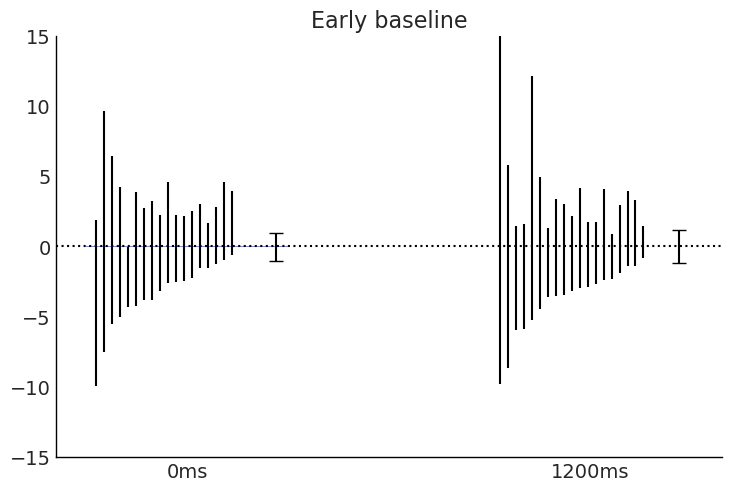

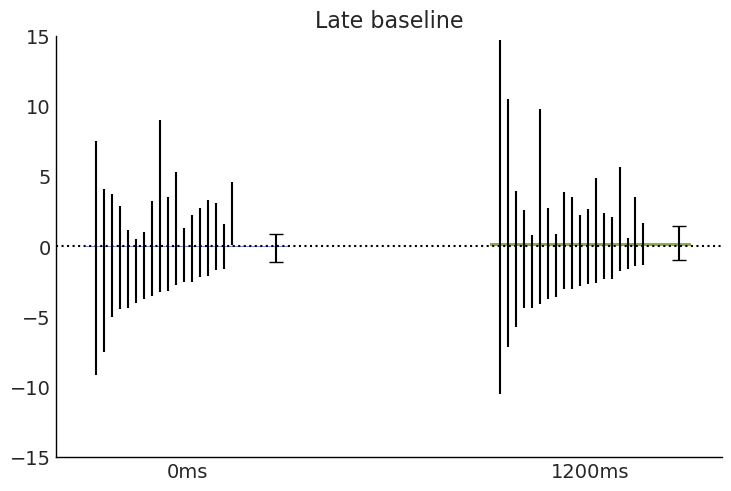

In [56]:
# Function to plot bars with error bars and subject lines
def plot_baseline(ax, means, HDIs, subjHDIs, title):
    x_ticks = np.arange(2)
    x_labels = ['0ms', '1200ms']
    y_ticks = np.arange(-15, 16, 5)
    ylimits = [-15, 15]
    bar_width = 0.5
    bar_colors = [[0.5, 0.5470, 0.8410], [0.5660, 0.6740, 0.2880]]
    
    # Plot bars
    for i, mean in enumerate(means):
        ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
    
    # Plot error bars
    for i in range(len(means)):
        ax.errorbar(x_ticks[i]+0.22, means[i], yerr=[[-HDIs[i][0]], [-HDIs[i][1]]], fmt='none', ecolor='black', capsize=5)
    
    # Plot subject lines
    line_offsets = np.linspace((-bar_width+0.05)/2, bar_width/2, 25)
    for gpNum in range(numGroups):
        gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
        numS = len(gpS)
        subjHDIs_gp = sorted(subjHDIs[gpNum], key=lambda x: x[0][0])  # Sort by lower bound
        for s in range(numS):
            line_x = x_ticks[gpNum] + line_offsets[s]
            ax.vlines(line_x, subjHDIs_gp[s][0][0], subjHDIs_gp[s][0][1], color='black')
    
    # Set plot properties
    ax.set_title(title)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    ax.set_ylim(ylimits)
    ax.axhline(0, color='black', linestyle=':')

# Plot early baseline
fig, ax = plt.subplots()
plot_baseline(ax, sortedEpsBeh['earlyBaseMeansAll'], sortedEpsBeh['earlyBaseHDI'], sortedEpsBeh['earlyBaseSubjHDI'], 'Early baseline')
plt.show()

# Plot late baseline
fig, ax = plt.subplots()
plot_baseline(ax, sortedEpsBeh['lateBaseMeansAll'], sortedEpsBeh['lateBaseHDI'], sortedEpsBeh['lateBaseSubjHDI'], 'Late baseline')
plt.show()


## adaptation

### hand

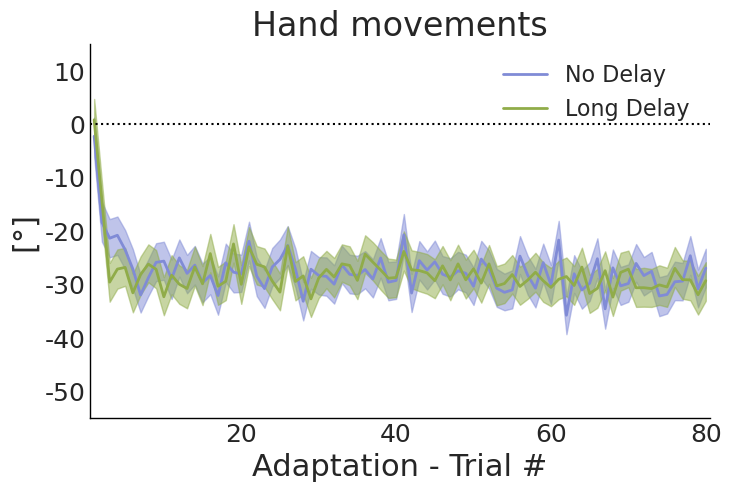

In [57]:
fig, ax = plt.subplots()

group1 = ax.plot(np.arange(1, 81), sortedEpsBeh['adaptMeansAll'][0], color=barColors[0], linewidth=2)
ax.fill_between(np.arange(1, 81), sortedEpsBeh['adaptHDIAll'][0][:, 0], sortedEpsBeh['adaptHDIAll'][0][:, 1],
                color=barColors[0], alpha=0.5)

group3 = ax.plot(np.arange(1, 81), sortedEpsBeh['adaptMeansAll'][1], color=barColors[1], linewidth=2)
ax.fill_between(np.arange(1, 81), sortedEpsBeh['adaptHDIAll'][1][:, 0], sortedEpsBeh['adaptHDIAll'][1][:, 1],
                color=barColors[1], alpha=0.5)

ax.legend([group1[0], group3[0]], ['No Delay', 'Long Delay'],fontsize=16,loc='upper right')
ax.set_title('Hand movements',fontsize=24)
ax.set_ylabel('[°]',fontsize=22)
ax.set_xlabel('Adaptation - Trial #',fontsize=22)
ax.axhline(0, linestyle=':', color='k')
#ax.set_xticks(np.arange(0, 80, 15)/2)
ax.set_xticks(np.arange(0, 81, 20))
ax.set_xticklabels(np.arange(0, 81, 20),fontsize=18)  
ax.set_yticks(np.arange(-50, 20, 10))
ax.set_yticklabels(np.arange(-50, 20, 10),fontsize=18)
ax.set_ylim(-55, 15)
ax.set_xlim(0.5, 80.5) 
plt.savefig("adapt_hand.jpg")
plt.show()


### eye

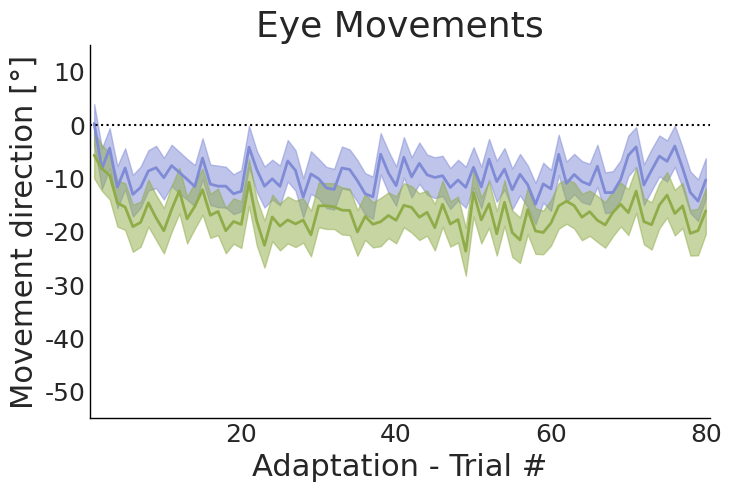

In [58]:
fig, ax = plt.subplots()


ax.fill_between(np.arange(1, 81), sortedEpsEyes['adaptHDIAll'][0][:, 0], sortedEpsEyes['adaptHDIAll'][0][:, 1],
                color=barColors[0], alpha=0.5)
group1 = ax.plot(np.arange(1, 81), sortedEpsEyes['adaptMeansAll'][0], color=barColors[0], linewidth=2)


ax.fill_between(np.arange(1, 81), sortedEpsEyes['adaptHDIAll'][1][:, 0], sortedEpsEyes['adaptHDIAll'][1][:, 1],
                color=barColors[1], alpha=0.5)
group3 = ax.plot(np.arange(1, 81), sortedEpsEyes['adaptMeansAll'][1], color=barColors[1], linewidth=2)

# ax.legend([group1[0], group3[0]], ['No Delay', 'Long Delay'], fontsize=16)
ax.set_title('Eye Movements', fontsize=26)
ax.set_ylabel('Movement direction [°]', fontsize=22)
ax.set_xlabel('Adaptation - Trial #', fontsize=22)
ax.axhline(0, linestyle=':', color='k')
#ax.set_xticks(np.arange(0, 80, 15)/2)
ax.set_xticks(np.arange(0, 81, 20))
ax.set_xticklabels(np.arange(0, 81, 20),fontsize=18)  
ax.set_yticks(np.arange(-50, 20, 10))
ax.set_yticklabels(np.arange(-50, 20, 10),fontsize=18)
ax.set_ylim(-55, 15)
ax.set_xlim(0.5, 80.5) 
plt.savefig("adapt_eye.jpg")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


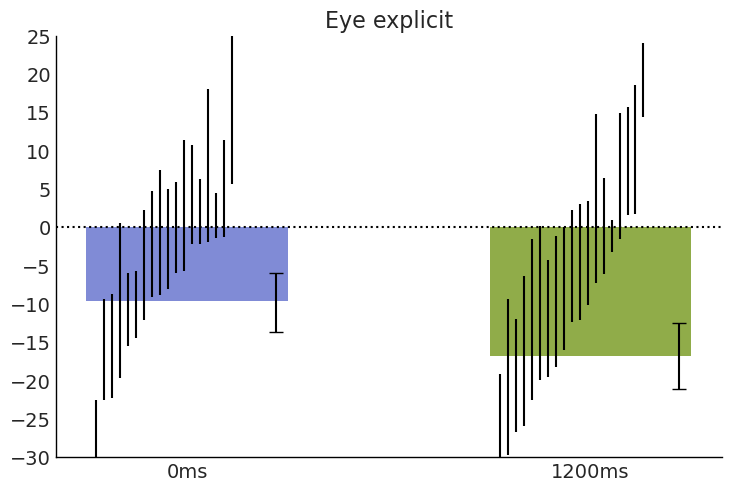

In [59]:
# Function to plot bars with error bars and subject lines
def plot_ad(ax, means, HDIs, subjHDIs, title):
    x_ticks = np.arange(2)
    x_labels = ['0ms', '1200ms']
    y_ticks = np.arange(-30, 26, 5)
    ylimits = [-30, 25]
    bar_width = 0.5
    bar_colors = [[0.5, 0.5470, 0.8410], [0.5660, 0.6740, 0.2880]]
    
    # Plot bars
    for i, mean in enumerate(means):
        ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
    
    # Plot error bars
    for i in range(len(means)):
        ax.errorbar(x_ticks[i]+0.22, means[i], yerr=[[-HDIs[i][0][0]], [-HDIs[i][0][1]]], fmt='none', ecolor='black', capsize=5)
    
    # Plot subject lines
    line_offsets = np.linspace((-bar_width+0.05)/2, bar_width/2, 25)
    for gpNum in range(numGroups):
        gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
        numS = len(gpS)
        subjHDIs_gp = sorted(subjHDIs[gpNum], key=lambda x: x[0][0])  # Sort by lower bound
        for s in range(numS):
            line_x = x_ticks[gpNum] + line_offsets[s]
            ax.vlines(line_x, subjHDIs_gp[s][0][0], subjHDIs_gp[s][0][1], color='black')
    
    # Set plot properties
    ax.set_title(title)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    ax.set_ylim(ylimits)
    ax.axhline(0, color='black', linestyle=':')
    ax.legend()

# Plot adaptation
fig, ax = plt.subplots()
adapt_means = [sortedEpsEyes['adaptMeansAll'][0].mean(), sortedEpsEyes['adaptMeansAll'][1].mean()]
plot_ad(ax, adapt_means, sortedEpsEyes['adaptHDI'], sortedEpsEyes['afterSubjHDI'], 'Eye explicit')
# plt.savefig("adapt_eye_subjs.jpg")
plt.show()

## aftereffect

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


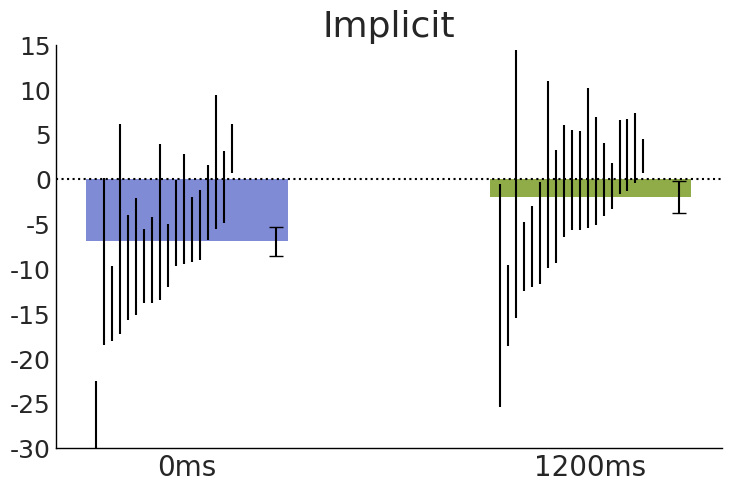

In [60]:
# Function to plot bars with error bars and subject lines
def plot_ae(ax, means, HDIs, subjHDIs, title):
    x_ticks = np.arange(2)
    x_labels = ['0ms', '1200ms']
    y_ticks = np.arange(-30, 16, 5)
    ylimits = [-30, 15]
    bar_width = 0.5
    bar_colors = [[0.5, 0.5470, 0.8410], [0.5660, 0.6740, 0.2880]]
    
    # Plot bars
    for i, mean in enumerate(means):
        ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
    
    # Plot error bars
    for i in range(len(means)):
        ax.errorbar(x_ticks[i]+0.22, means[i], yerr=[[-HDIs[i][0]], [-HDIs[i][1]]], fmt='none', ecolor='black', capsize=5)
    
    # Plot subject lines
    line_offsets = np.linspace((-bar_width+0.05)/2, bar_width/2, 25)
    for gpNum in range(numGroups):
        gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
        numS = len(gpS)
        subjHDIs_gp = sorted(subjHDIs[gpNum], key=lambda x: x[0][0])  # Sort by lower bound
        for s in range(numS):
            line_x = x_ticks[gpNum] + line_offsets[s]
            ax.vlines(line_x, subjHDIs_gp[s][0][0], subjHDIs_gp[s][0][1], color='black')
    
    # Set plot properties
    ax.set_title(title, fontsize=26)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=20)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=18)
    ax.set_ylim(ylimits)
    ax.axhline(0, color='black', linestyle=':')
    ax.legend(fontsize=18)

# Plot aftereffect
fig, ax = plt.subplots()
plot_ae(ax, sortedEpsBeh['implicitMeansAll'], sortedEpsBeh['implicitHDI'], sortedEpsBeh['implicitSubjHDI'], 'Implicit')
plt.show()

In [61]:
## aftereffect differences between groups
# Calculate HDI for error bars
# Calculate aftereffect differences
afterDiff = np.mean(sortedEpsBeh['implicitSamples'][0] - sortedEpsBeh['implicitSamples'][1])
afterDiffHDI = np.percentile(sortedEpsBeh['implicitSamples'][0] - sortedEpsBeh['implicitSamples'][1], [5.0, 95.0])
print(afterDiff)
print(afterDiffHDI)

-4.930275449106542
[-7.06938064 -2.8570362 ]


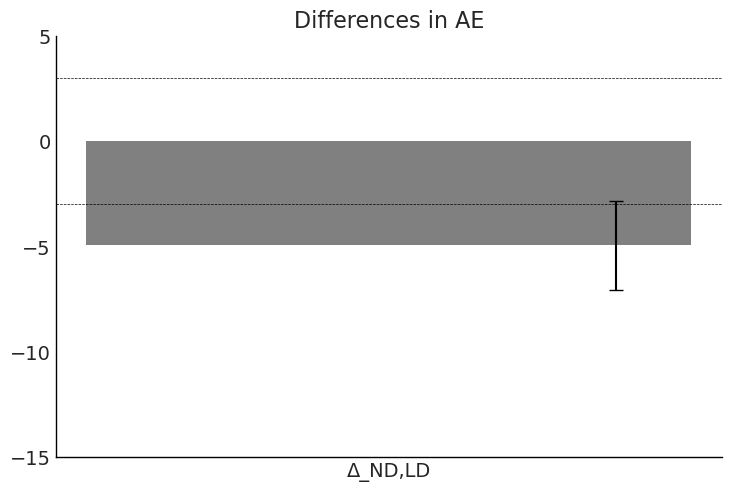

In [62]:
diff_color = [0.5, 0.5, 0.5]

# Plot aftereffect differences
fig, ax = plt.subplots()
x_ticks = np.arange(1)
x_labels = ['\u0394_ND,LD']
y_ticks = np.arange(-15, 6, 5)
ylimits = [-15, 5]

# Plot bar
ax.bar(x_ticks, afterDiff, color=diff_color)

# Plot error bars
ax.errorbar(x_ticks + 0.3, afterDiff, yerr=[[afterDiff-afterDiffHDI[0]], [afterDiffHDI[1]-afterDiff]], fmt='none', ecolor='black', capsize=5)
#ax.errorbar(x_ticks + 0.3, afterDiff, yerr=0.5, fmt='none', ecolor='black', capsize=5)
# ROPE range
ax.axhline(3, color='black', linestyle='--', linewidth=0.5)
ax.axhline(-3, color='black', linestyle='--', linewidth=0.5)
# Set plot properties
ax.set_title('Differences in AE')
# ax.set_ylabel('\u0394 [°]')
#ax.axhline([-3, 3], color='black', linestyle='--')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_ylim(ylimits)

plt.savefig("AE_difference.jpg")
plt.show()


In [63]:
## implicit difference
implicitEye = [[] for _ in range(numGroups)]
implicitEyeHDI = [[] for _ in range(numGroups)]
afterSubjHDI = sortedEpsBeh['implicitSubjHDI']

# compare raw data and model output

## baseline

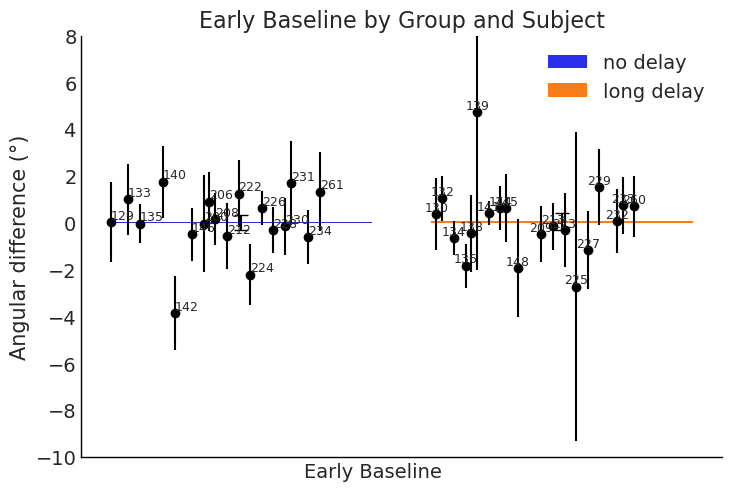

In [64]:
# 初始化存储每个组数据的列表
group_A_earlyBaseline = []
group_B_earlyBaseline = []

# Get unique subject IDs
unique_subj_ids = allTable['subj_id'].unique()

# Calculate earlyBaseline for each subject
for subj_id in unique_subj_ids:
    # Filter rows corresponding to the current subject
    subj_data = allTable[allTable['subj_id'] == subj_id]
    handError = subj_data['errorCorrect'].values
    earlyBaseline = np.mean(handError[0:25])
    group = subj_data['gp'].values[0]
    if group == 0:
        group_A_earlyBaseline.append(earlyBaseline)
    elif group == 1:
        group_B_earlyBaseline.append(earlyBaseline)

# 计算每个组的平均earlyBaseline
mean_A_earlyBaseline = np.nanmean(group_A_earlyBaseline)
mean_B_earlyBaseline = np.nanmean(group_B_earlyBaseline)

# 计算每个组的标准误差
stderr_A_earlyBaseline = np.nanstd(group_A_earlyBaseline) / np.sqrt(len(group_A_earlyBaseline))
stderr_B_earlyBaseline = np.nanstd(group_B_earlyBaseline) / np.sqrt(len(group_B_earlyBaseline))

# 绘制柱状图
bar_width = 0.9
index = np.arange(1)
fig, ax = plt.subplots()

bars_A = ax.bar(index, mean_A_earlyBaseline, bar_width, label='no delay', yerr=stderr_A_earlyBaseline, capsize=5)
bars_B = ax.bar(index + bar_width+0.2, mean_B_earlyBaseline, bar_width, label='long delay', yerr=stderr_B_earlyBaseline, capsize=5)

# Add subject data to the plot
for i, subj_id in enumerate(unique_subj_ids):
    subj_data = allTable[allTable['subj_id'] == subj_id]
    group = subj_data['gp'].values[0]
    handError = subj_data['errorCorrect'].values
    mean_handError = np.nanmean(handError[0:25])
    std_handError = np.nanstd(handError[0:25]) / np.sqrt(25)
    if group == 0:
        ax.errorbar(index - 0.45 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index - 0.45 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='left', va='bottom')
    elif group == 1:
        ax.errorbar(index + bar_width - 0.25 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index + bar_width - 0.25 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='center', va='bottom')

# 添加图例
ax.legend()

ax.set_ylim(-10, 8)
# 设置轴标签和标题
ax.set_ylabel('Angular difference (°)')
ax.set_title('Early Baseline by Group and Subject')

# 设置x轴刻度标签
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Early Baseline'])

plt.show()

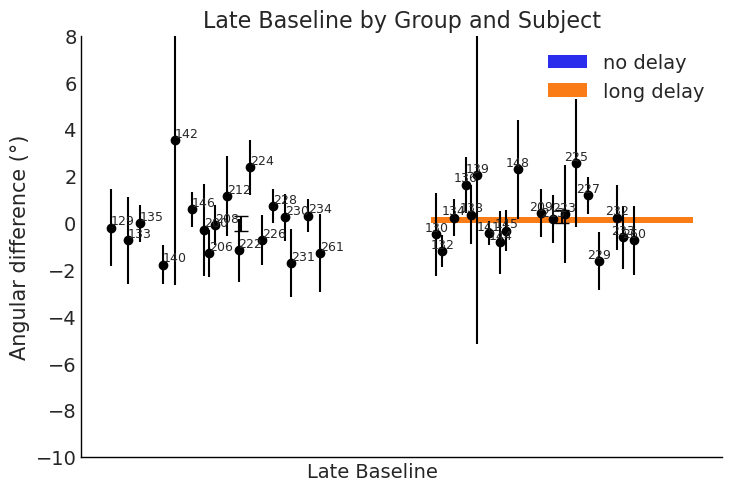

In [65]:
# 初始化存储每个组数据的列表
group_A_lateBaseline = []
group_B_lateBaseline = []

# Get unique subject IDs
unique_subj_ids = allTable['subj_id'].unique()

# Calculate earlyBaseline for each subject
for subj_id in unique_subj_ids:
    # Filter rows corresponding to the current subject
    subj_data = allTable[allTable['subj_id'] == subj_id]
    handError = subj_data['errorCorrect'].values
    lateBaseline = np.mean(handError[25:50])
    group = subj_data['gp'].values[0]
    if group == 0:
        group_A_lateBaseline.append(lateBaseline)
    elif group == 1:
        group_B_lateBaseline.append(lateBaseline)

# 计算每个组的平均earlyBaseline
mean_A_lateBaseline = np.nanmean(group_A_lateBaseline)
mean_B_lateBaseline = np.nanmean(group_B_lateBaseline)

# 计算每个组的标准误差
stderr_A_lateBaseline = np.nanstd(group_A_lateBaseline) / np.sqrt(len(group_A_lateBaseline))
stderr_B_lateBaseline = np.nanstd(group_B_lateBaseline) / np.sqrt(len(group_B_lateBaseline))

# 绘制柱状图
bar_width = 0.9
index = np.arange(1)
fig, ax = plt.subplots()

bars_A = ax.bar(index, mean_A_lateBaseline, bar_width, label='no delay', yerr=stderr_A_lateBaseline, capsize=5)
bars_B = ax.bar(index + bar_width+0.2, mean_B_lateBaseline, bar_width, label='long delay', yerr=stderr_B_lateBaseline, capsize=5)

# Add subject data to the plot
for i, subj_id in enumerate(unique_subj_ids):
    subj_data = allTable[allTable['subj_id'] == subj_id]
    group = subj_data['gp'].values[0]
    handError = subj_data['errorCorrect'].values
    mean_handError = np.nanmean(handError[25:50])
    std_handError = np.nanstd(handError[25:50]) / np.sqrt(25)
    if group == 0:
        ax.errorbar(index - 0.45 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index - 0.45 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='left', va='bottom')
    elif group == 1:
        ax.errorbar(index + bar_width - 0.25 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index + bar_width - 0.25 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='center', va='bottom')

# 添加图例
ax.legend()

ax.set_ylim(-10, 8)
# 设置轴标签和标题
ax.set_ylabel('Angular difference (°)')
ax.set_title('Late Baseline by Group and Subject')

# 设置x轴刻度标签
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Late Baseline'])

plt.show()


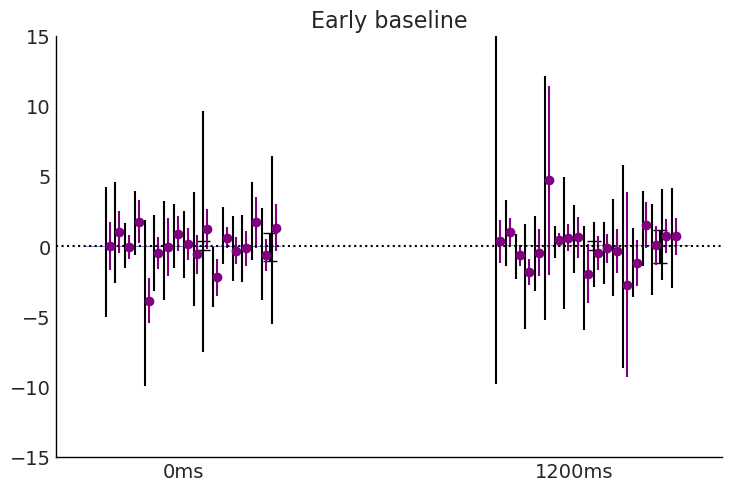

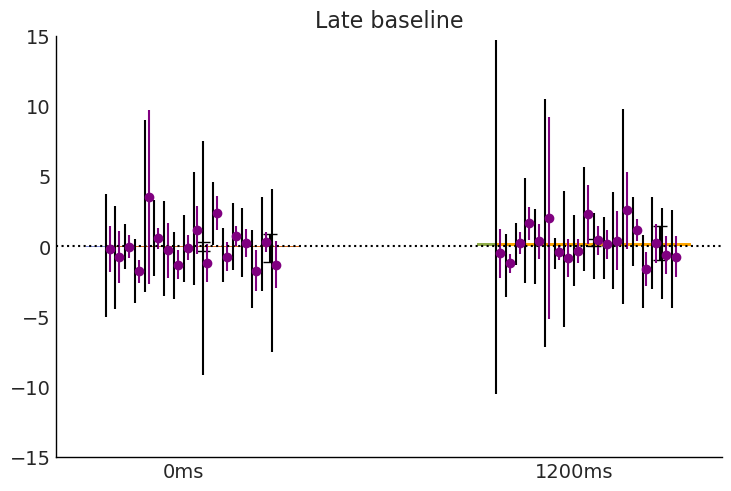

In [66]:
## plot model output and actual data together
# Plot early baseline
fig, ax = plt.subplots()
x_ticks = np.arange(2)
x_labels = ['0ms', '1200ms']
y_ticks = np.arange(-15, 16, 5)
ylimits = [-15, 15]
# Plot bars
bar_width = 0.5
bar_colors = [[0.5, 0.5470, 0.8410], [0.5660, 0.6740, 0.2880]]
early_means = sortedEpsBeh['earlyBaseMeansAll']
early_HDIs = sortedEpsBeh['earlyBaseHDI']
for i, mean in enumerate(early_means):
    ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
## true mean value
ax.bar(0+0.05, mean_A_earlyBaseline, bar_width, color='chocolate', yerr=stderr_A_earlyBaseline, capsize=5)
ax.bar(1+0.05, mean_B_earlyBaseline, bar_width, color='orange', yerr=stderr_B_earlyBaseline, capsize=5)

# Plot error bars
for i in range(len(early_means)):
    ax.errorbar(x_ticks[i]+0.22, early_means[i], yerr=[[-early_HDIs[i][0]],[-early_HDIs[i][1]]], fmt='none', ecolor='black', capsize=5)

# Plot subject lines
line_offsets = np.linspace((-bar_width+0.1)/2, bar_width/2, numS)  # 在每个柱状条内部均匀分布竖直线的偏移量
for gpNum in range(numGroups):
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numSubj = len(gpS)
    for s in range(numSubj):
        line_x = x_ticks[gpNum] + line_offsets[s]  # 计算竖直线的x位置
        ax.vlines(line_x, sortedEpsBeh['earlyBaseSubjHDI'][gpNum][s][0][0], sortedEpsBeh['earlyBaseSubjHDI'][gpNum][s][0][1], color='black')       
        # Plot true error bars 
        subj = subjectTable.loc[gpS[s], 'subjectST']  # Get subject ID
        subj_data = allTable[allTable['subject'] == subj]  # Get data for the subject
        handError = subj_data['errorCorrect'].values
        ax.errorbar(line_x+0.01, np.nanmean(handError[0:25]), 
                    yerr=np.nanstd(handError[0:25]) / np.sqrt(25), 
                    fmt='o', color='purple')


# Set plot properties
ax.set_title('Early baseline')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_ylim(ylimits)
ax.axhline(0, color='black', linestyle=':')
# ax.legend()

# plt.savefig("early_baseline.jpg")
# plt.show()


# Plot late baseline
fig, ax = plt.subplots()
# Plot bars
late_means = sortedEpsBeh['lateBaseMeansAll']
late_HDIs = sortedEpsBeh['lateBaseHDI']
for i, mean in enumerate(late_means):
    ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
## true mean value
ax.bar(0+0.05, mean_A_lateBaseline, bar_width, color='chocolate', yerr=stderr_A_lateBaseline, capsize=5)
ax.bar(1+0.05, mean_B_lateBaseline, bar_width, color='orange', yerr=stderr_B_lateBaseline, capsize=5)    

# Plot error bars
for i in range(len(late_means)):
    ax.errorbar(x_ticks[i]+0.22, late_means[i], yerr=[[-late_HDIs[i][0]],[-late_HDIs[i][1]]], fmt='none', ecolor='black', capsize=5)

# Plot subject lines
line_offsets = np.linspace((-bar_width+0.1)/2, bar_width/2, numS)  # 在每个柱状条内部均匀分布竖直线的偏移量
for gpNum in range(numGroups):
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numSubj = len(gpS)
    for s in range(numSubj):
        line_x = x_ticks[gpNum] + line_offsets[s]  # 计算竖直线的x位置
        ax.vlines(line_x, sortedEpsBeh['lateBaseSubjHDI'][gpNum][s][0][0], sortedEpsBeh['lateBaseSubjHDI'][gpNum][s][0][1], color='black')
        # Plot true error bars 
        subj = subjectTable.loc[gpS[s], 'subjectST']  # Get subject ID
        subj_data = allTable[allTable['subject'] == subj]  # Get data for the subject
        handError = subj_data['errorCorrect'].values
        ax.errorbar(line_x+0.01, np.nanmean(handError[25:50]), 
                    yerr=np.nanstd(handError[25:50]) / np.sqrt(25), 
                    fmt='o', color='purple')
        
# Set plot properties
ax.set_title('Late baseline')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_ylim(ylimits)
ax.axhline(0, color='black', linestyle=':')
# ax.legend()

## aftereffect

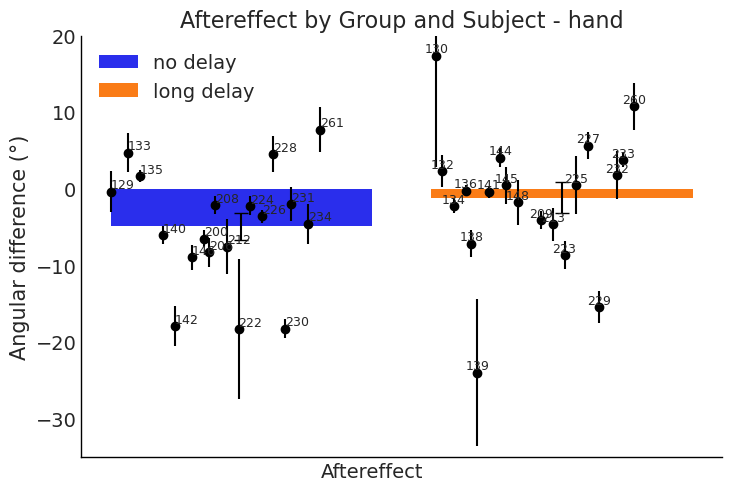

In [67]:
######################################hand of last 12 trials in aftereffect###############################
# 初始化存储每个组数据的列表
group_A_aftereffect = []
group_B_aftereffect = []

# Get unique subject IDs
unique_subj_ids = allTable['subj_id'].unique()

# Calculate earlyBaseline for each subject
for subj_id in unique_subj_ids:
    # Filter rows corresponding to the current subject
    subj_data = allTable[allTable['subj_id'] == subj_id]
    handError = subj_data['errorCorrect'].values
    aftereffect = np.nanmean(handError[138:150])
    group = subj_data['gp'].values[0]
    if group == 0:
        group_A_aftereffect.append(aftereffect)
    elif group == 1:
        group_B_aftereffect.append(aftereffect)

# 计算每个组的平均earlyBaseline
mean_A_aftereffect = np.nanmean(group_A_aftereffect)
mean_B_aftereffect = np.nanmean(group_B_aftereffect)

# 计算每个组的标准误差
stderr_A_aftereffect = np.nanstd(group_A_aftereffect) / np.sqrt(len(group_A_aftereffect))
stderr_B_aftereffect = np.nanstd(group_B_aftereffect) / np.sqrt(len(group_B_aftereffect))

# 绘制柱状图
bar_width = 0.9
index = np.arange(1)
fig, ax = plt.subplots()

bars_A = ax.bar(index, mean_A_aftereffect, bar_width, label='no delay', yerr=stderr_A_aftereffect, capsize=5)
bars_B = ax.bar(index + bar_width+0.2, mean_B_aftereffect, bar_width, label='long delay', yerr=stderr_B_aftereffect, capsize=5)

# Add subject data to the plot
for i, subj_id in enumerate(unique_subj_ids):
    subj_data = allTable[allTable['subj_id'] == subj_id]
    group = subj_data['gp'].values[0]
    handError = subj_data['errorCorrect'].values
    mean_handError = np.nanmean(handError[138:150])
    std_handError = np.nanstd(handError[138:150]) / np.sqrt(12)
    if group == 0:
        ax.errorbar(index - 0.45 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index - 0.45 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='left', va='bottom')
    elif group == 1:
        ax.errorbar(index + bar_width - 0.25 + 0.02 * i, mean_handError, yerr=std_handError, fmt='o', color='black')
        ax.text(index + bar_width - 0.25 + 0.02 * i, mean_handError, subj_id, fontsize=9, ha='center', va='bottom')

# 添加图例
ax.legend()

ax.set_ylim(-35, 20)
# 设置轴标签和标题
ax.set_ylabel('Angular difference (°)')
ax.set_title('Aftereffect by Group and Subject - hand')

# 设置x轴刻度标签
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(['Aftereffect'])

plt.show()

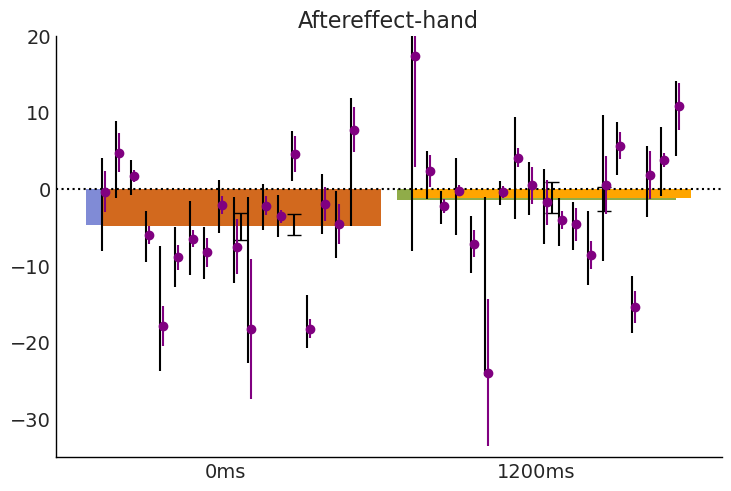

In [68]:
# Plot aftereffect
fig, ax = plt.subplots()
# Plot bars
after_means = sortedEpsBeh['afterMeansAll']
after_HDIs = sortedEpsBeh['afterHDI']
for i, mean in enumerate(after_means):
    ax.bar(x_ticks[i], mean, bar_width, color=bar_colors[i])
## true mean value
ax.bar(0+0.05, mean_A_aftereffect, bar_width, color='chocolate', yerr=stderr_A_aftereffect, capsize=5)
ax.bar(1+0.05, mean_B_aftereffect, bar_width, color='orange', yerr=stderr_B_aftereffect, capsize=5)    

# Plot error bars
for i in range(len(after_means)):
    ax.errorbar(x_ticks[i]+0.22, after_means[i], yerr=[[-after_HDIs[i][0]],[-after_HDIs[i][1]]], fmt='none', ecolor='black', capsize=5)

# Plot subject lines
line_offsets = np.linspace((-bar_width+0.1)/2, bar_width/2, numS)  # 在每个柱状条内部均匀分布竖直线的偏移量
for gpNum in range(numGroups):
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numSubj = len(gpS)
    for s in range(numSubj):
        line_x = x_ticks[gpNum] + line_offsets[s]  # 计算竖直线的x位置
        ax.vlines(line_x, sortedEpsBeh['afterSubjHDI'][gpNum][s][0][0], sortedEpsBeh['afterSubjHDI'][gpNum][s][0][1], color='black')
        # Plot true error bars 
        subj = subjectTable.loc[gpS[s], 'subjectST']  # Get subject ID
        subj_data = allTable[allTable['subject'] == subj]  # Get data for the subject
        handError = subj_data['errorCorrect'].values
        ax.errorbar(line_x+0.01, np.nanmean(handError[138:150]), 
                    yerr=np.nanstd(handError[138:150]) / np.sqrt(12), 
                    fmt='o', color='purple')
        
# Set plot properties
ax.set_title('Aftereffect-hand')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_ylim(-35, 20)
ax.axhline(0, color='black', linestyle=':')
# ax.legend()

## adaptation

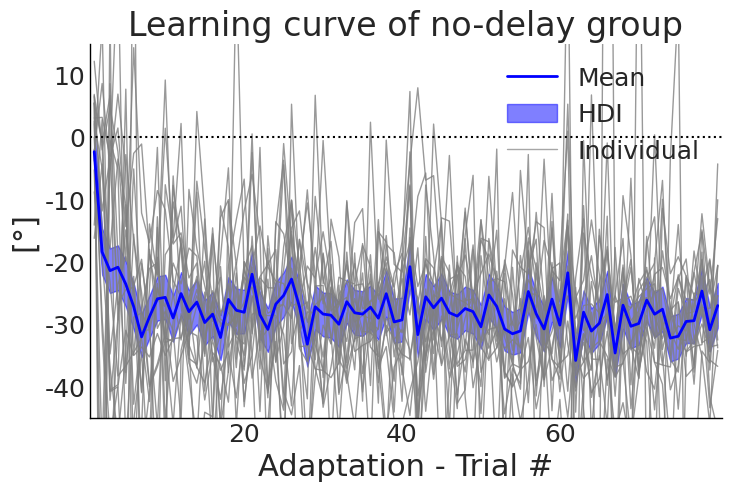

In [69]:
fig, ax = plt.subplots()

# Plot individual subject lines
for subj in allTable[allTable['gp'] == 0]['subject'].unique():
    subj_data = allTable[allTable['subject'] == subj]
    errorCorrect = subj_data['errorCorrect'].values[50:130]
    ax.plot(np.arange(1, 81), errorCorrect, color='gray', linewidth=1, alpha=0.8)

# Plot mean and HDI
group1 = ax.plot(np.arange(1, 81), sortedEpsBeh['adaptMeansAll'][0], color='b', linewidth=2)
hdi1 = ax.fill_between(np.arange(1, 81), sortedEpsBeh['adaptHDIAll'][0][:, 0], sortedEpsBeh['adaptHDIAll'][0][:, 1],
                color='b', alpha=0.5)

# Add legend
individual_line = plt.Line2D([0], [0], color='gray', linewidth=1, alpha=0.7)

ax.legend([group1[0], hdi1, individual_line], ['Mean', 'HDI', 'Individual'], fontsize=18)

# Set title and labels
ax.set_title('Learning curve of no-delay group', fontsize=24)
ax.set_ylabel('[°]', fontsize=22)
ax.set_xlabel('Adaptation - Trial #', fontsize=22)

# Set grid, ticks, and limits
ax.axhline(0, linestyle=':', color='k')
ax.set_xticks(np.arange(0, 80, 20))
ax.set_xticklabels(np.arange(0, 80, 20), fontsize=18)
ax.set_yticks(np.arange(-40, 20, 10))
ax.set_yticklabels(np.arange(-40, 20, 10), fontsize=18)
ax.set_ylim(-45, 15)
ax.set_xlim(0.5, 80.5)

plt.show()


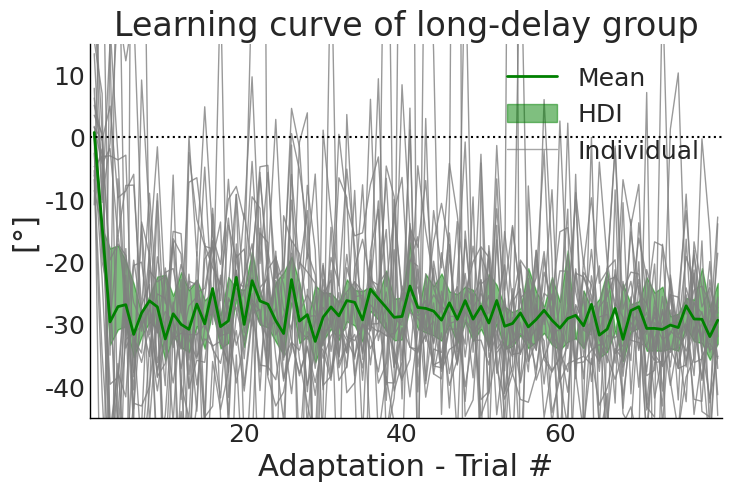

In [70]:
fig, ax = plt.subplots()

# Plot individual subject lines
for subj in allTable[allTable['gp'] == 1]['subject'].unique():
    subj_data = allTable[allTable['subject'] == subj]
    errorCorrect = subj_data['errorCorrect'].values[50:130]
    ax.plot(np.arange(1, 81), errorCorrect, color='gray', linewidth=1, alpha=0.8)

# Plot mean and HDI
group2 = ax.plot(np.arange(1, 81), sortedEpsBeh['adaptMeansAll'][1], color='g', linewidth=2)
hdi2 = ax.fill_between(np.arange(1, 81), sortedEpsBeh['adaptHDIAll'][1][:, 0], sortedEpsBeh['adaptHDIAll'][0][:, 1],
                color='g', alpha=0.5)

# Add legend
individual_line = plt.Line2D([0], [0], color='gray', linewidth=1, alpha=0.7)

ax.legend([group2[0], hdi2, individual_line], ['Mean', 'HDI', 'Individual'], fontsize=18)

# Set title and labels
ax.set_title('Learning curve of long-delay group', fontsize=24)
ax.set_ylabel('[°]', fontsize=22)
ax.set_xlabel('Adaptation - Trial #', fontsize=22)

# Set grid, ticks, and limits
ax.axhline(0, linestyle=':', color='k')
ax.set_xticks(np.arange(0, 80, 20))
ax.set_xticklabels(np.arange(0, 80, 20), fontsize=18)
ax.set_yticks(np.arange(-40, 20, 10))
ax.set_yticklabels(np.arange(-40, 20, 10), fontsize=18)
ax.set_ylim(-45, 15)
ax.set_xlim(0.5, 80.5)

plt.show()


## overall mean and hdi and data during all trials

In [71]:
handColors = ['blue', 'brown']
eyeColors = ['darkgreen', 'chocolate']

In [72]:
# get mean of all subjects across all trials
# 按trialNum和gp分组，计算errorCorrect均值
mean_handError = allTable.groupby(['trialNum', 'gp'])['errorCorrect'].mean().reset_index()
mean_eyeError = allTable.groupby(['trialNum', 'gp'])['eyeError'].mean().reset_index()

# 分别获取gp为0和gp为1时的均值
gp0_mean_handError = mean_handError[mean_handError['gp'] == 0]
gp1_mean_handError = mean_handError[mean_handError['gp'] == 1]
gp0_mean_eyeError = mean_eyeError[mean_eyeError['gp'] == 0]
gp1_mean_eyeError = mean_eyeError[mean_eyeError['gp'] == 1]


(0.0, 150.0)

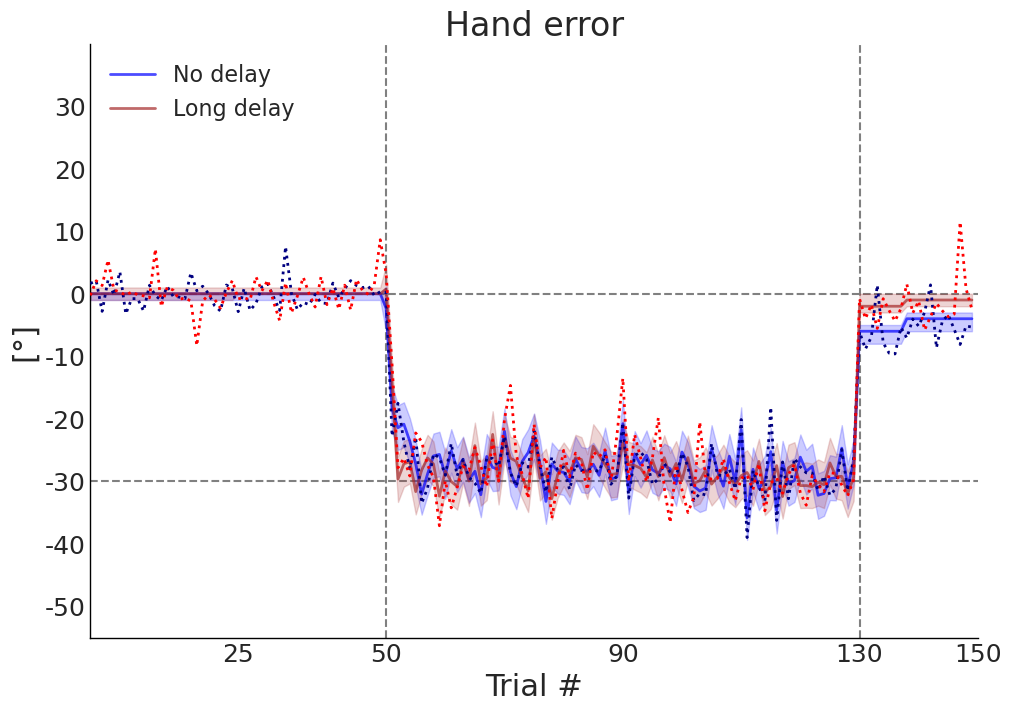

In [73]:
# 合并时间段数据
x_full = np.concatenate((np.arange(0, 25), np.arange(25, 50), np.arange(50, 130), np.arange(130, 138), np.arange(138, 150)))
y_full_gp0 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseMeansAll'][0]),
                             np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseMeansAll'][0]),
                             sortedEpsBeh['adaptMeansAll'][0],
                             np.full_like(np.arange(130, 138), sortedEpsBeh['implicitMeansAll'][0][0]),
                             np.full_like(np.arange(138, 150), sortedEpsBeh['afterMeansAll'][0][0])))
y_full_gp1 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseMeansAll'][1]),
                             np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseMeansAll'][1]),
                             sortedEpsBeh['adaptMeansAll'][1],
                             np.full_like(np.arange(130, 138), sortedEpsBeh['implicitMeansAll'][1][0]),
                             np.full_like(np.arange(138, 150), sortedEpsBeh['afterMeansAll'][1][0])))

# 合并HDI数据
hdi_full_gp0_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseHDIAll'][0][0, 0]),
                                   np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseHDIAll'][0][0, 0]),
                                   sortedEpsBeh['adaptHDIAll'][0][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsBeh['implicitHDIAll'][0][0, 0]),
                                   np.full_like(np.arange(138, 150), sortedEpsBeh['afterHDIAll'][0][0, 0])))
hdi_full_gp0_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseHDIAll'][0][0, 1]),
                                    np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseHDIAll'][0][0, 1]),
                                    sortedEpsBeh['adaptHDIAll'][0][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsBeh['implicitHDIAll'][0][0, 1]),
                                    np.full_like(np.arange(138, 150), sortedEpsBeh['afterHDIAll'][0][0, 1])))
hdi_full_gp1_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseHDIAll'][1][0, 0]),
                                   np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseHDIAll'][1][0, 0]),
                                   sortedEpsBeh['adaptHDIAll'][1][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsBeh['implicitHDIAll'][1][0, 0]),
                                   np.full_like(np.arange(138, 150), sortedEpsBeh['afterHDIAll'][1][0, 0])))
hdi_full_gp1_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsBeh['earlyBaseHDIAll'][1][0, 1]),
                                    np.full_like(np.arange(25, 50), sortedEpsBeh['lateBaseHDIAll'][1][0, 1]),
                                    sortedEpsBeh['adaptHDIAll'][1][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsBeh['implicitHDIAll'][1][0, 1]),
                                    np.full_like(np.arange(138, 150), sortedEpsBeh['afterHDIAll'][1][0, 1])))

# 画图
fig, ax = plt.subplots(figsize=(10, 7))

# 绘制合并后的数据
model_mean_gp0 = ax.plot(x_full, y_full_gp0, color=handColors[0], linewidth=2, label='model mean (no delay)', zorder=2, alpha=0.7)
model_mean_gp1 = ax.plot(x_full, y_full_gp1, color=handColors[1], linewidth=2, label='model mean (long delay)', zorder=2, alpha=0.7)
# 绘制HDI区域
hdi_gp0 = ax.fill_between(x_full, hdi_full_gp0_low, hdi_full_gp0_high, color=handColors[0], alpha=0.2, zorder=1)
hdi_gp1 = ax.fill_between(x_full, hdi_full_gp1_low, hdi_full_gp1_high, color=handColors[1], alpha=0.2, zorder=1)
# 绘制mean data
mean_gp0 = ax.plot(x_full, gp0_mean_handError['errorCorrect'], color='navy', linewidth=2, linestyle=':', zorder=3, alpha=1)
mean_gp1 = ax.plot(x_full, gp1_mean_handError['errorCorrect'], color='red', linewidth=2, linestyle=':', zorder=3, alpha=1)


# ax.legend([model_mean_gp0[0], model_mean_gp1[0], hdi_gp0, hdi_gp1, mean_gp0[0], mean_gp1[0]], 
#           ['model mean (no delay)', 'model mean (long delay)', 'HDI (no delay)', 'HDI (long delay)', 'mean (no delay)', 'mean (long delay)']
#           , fontsize=16,loc='upper right')
ax.legend([model_mean_gp0[0], model_mean_gp1[0]], 
          ['No delay', 'Long delay']
          , fontsize=16,loc='best')

ax.set_title('Hand error',fontsize=24)
ax.set_ylabel('[°]',fontsize=22)
ax.set_xlabel('Trial #',fontsize=22)
ax.axhline(0, linestyle='--', color='grey', zorder=0)
ax.axhline(-30, linestyle='--', color='grey', zorder=0)
ax.axvline(50, linestyle='--', color='grey', zorder=0)
ax.axvline(130, linestyle='--', color='grey', zorder=0)

ax.set_xticks([25, 50, 90, 130, 150])
ax.set_xticklabels([25, 50, 90, 130, 150],fontsize=18)  
ax.set_yticks(np.arange(-50, 40, 10))
ax.set_yticklabels(np.arange(-50, 40, 10),fontsize=18)
ax.set_ylim(-55, 40)
ax.set_xlim(0, 150) 



(0.0, 150.0)

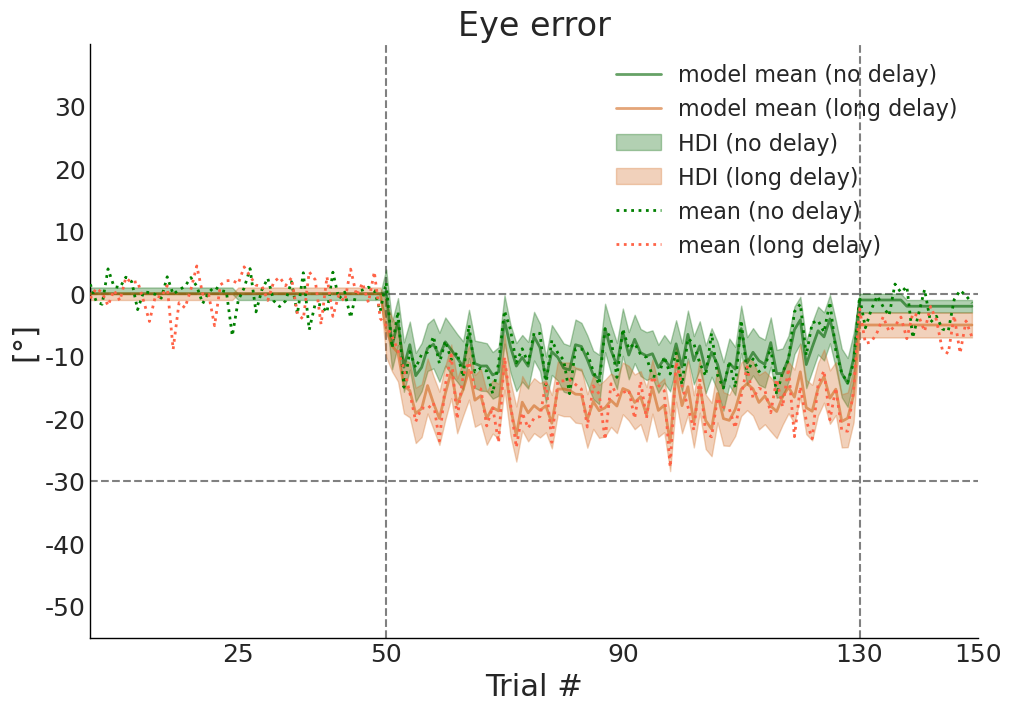

In [74]:
# 合并时间段数据
x_full = np.concatenate((np.arange(0, 25), np.arange(25, 50), np.arange(50, 130), np.arange(130, 138), np.arange(138, 150)))
y_full_gp0 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseMeansAll'][0]),
                             np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseMeansAll'][0]),
                             sortedEpsEyes['adaptMeansAll'][0],
                             np.full_like(np.arange(130, 138), sortedEpsEyes['implicitMeansAll'][0][0]),
                             np.full_like(np.arange(138, 150), sortedEpsEyes['afterMeansAll'][0][0])))
y_full_gp1 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseMeansAll'][1]),
                             np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseMeansAll'][1]),
                             sortedEpsEyes['adaptMeansAll'][1],
                             np.full_like(np.arange(130, 138), sortedEpsEyes['implicitMeansAll'][1][0]),
                             np.full_like(np.arange(138, 150), sortedEpsEyes['afterMeansAll'][1][0])))

# 合并HDI数据
hdi_full_gp0_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseHDIAll'][0][0, 0]),
                                   np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseHDIAll'][0][0, 0]),
                                   sortedEpsEyes['adaptHDIAll'][0][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsEyes['implicitHDIAll'][0][0, 0]),
                                   np.full_like(np.arange(138, 150), sortedEpsEyes['afterHDIAll'][0][0, 0])))
hdi_full_gp0_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseHDIAll'][0][0, 1]),
                                    np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseHDIAll'][0][0, 1]),
                                    sortedEpsEyes['adaptHDIAll'][0][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsEyes['implicitHDIAll'][0][0, 1]),
                                    np.full_like(np.arange(138, 150), sortedEpsEyes['afterHDIAll'][0][0, 1])))
hdi_full_gp1_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseHDIAll'][1][0, 0]),
                                   np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseHDIAll'][1][0, 0]),
                                   sortedEpsEyes['adaptHDIAll'][1][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsEyes['implicitHDIAll'][1][0, 0]),
                                   np.full_like(np.arange(138, 150), sortedEpsEyes['afterHDIAll'][1][0, 0])))
hdi_full_gp1_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsEyes['earlyBaseHDIAll'][1][0, 1]),
                                    np.full_like(np.arange(25, 50), sortedEpsEyes['lateBaseHDIAll'][1][0, 1]),
                                    sortedEpsEyes['adaptHDIAll'][1][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsEyes['implicitHDIAll'][1][0, 1]),
                                    np.full_like(np.arange(138, 150), sortedEpsEyes['afterHDIAll'][1][0, 1])))

# 画图
fig, ax = plt.subplots(figsize=(10, 7))

# 绘制合并后的数据
model_mean_gp0 = ax.plot(x_full, y_full_gp0, color=eyeColors[0], linewidth=2, label='model mean (no delay)', zorder=3, alpha=0.6)
model_mean_gp1 = ax.plot(x_full, y_full_gp1, color=eyeColors[1], linewidth=2, label='model mean (long delay)', zorder=3, alpha=0.6)
# 绘制HDI区域
hdi_gp0 = ax.fill_between(x_full, hdi_full_gp0_low, hdi_full_gp0_high, color=eyeColors[0], alpha=0.3, zorder=1)
hdi_gp1 = ax.fill_between(x_full, hdi_full_gp1_low, hdi_full_gp1_high, color=eyeColors[1], alpha=0.3, zorder=1)
# 绘制mean data
mean_gp0 = ax.plot(x_full, gp0_mean_eyeError['eyeError'], color='green', linewidth=2, linestyle=':', zorder=4, alpha=1)
mean_gp1 = ax.plot(x_full, gp1_mean_eyeError['eyeError'], color='tomato', linewidth=2, linestyle=':', zorder=4, alpha=1)


ax.legend([model_mean_gp0[0], model_mean_gp1[0], hdi_gp0, hdi_gp1, mean_gp0[0], mean_gp1[0]], 
          ['model mean (no delay)', 'model mean (long delay)', 'HDI (no delay)', 'HDI (long delay)', 'mean (no delay)', 'mean (long delay)']
          , fontsize=16,loc='upper right')

ax.set_title('Eye error',fontsize=24)
ax.set_ylabel('[°]',fontsize=22)
ax.set_xlabel('Trial #',fontsize=22)
ax.axhline(0, linestyle='--', color='grey', zorder=0)
ax.axhline(-30, linestyle='--', color='grey', zorder=0)
ax.axvline(50, linestyle='--', color='grey', zorder=0)
ax.axvline(130, linestyle='--', color='grey', zorder=0)

ax.set_xticks([25, 50, 90, 130, 150])
ax.set_xticklabels([25, 50, 90, 130, 150],fontsize=18)  
ax.set_yticks(np.arange(-50, 40, 10))
ax.set_yticklabels(np.arange(-50, 40, 10),fontsize=18)
ax.set_ylim(-55, 40)
ax.set_xlim(0, 150) 

In [75]:
# save data 
if SaveAllData == 1:
    file_path = 'sortedEpsBeh_2T.pkl'

    print('data saved')
    with open(file_path, 'wb') as f:
        pickle.dump(sortedEpsBeh, f)

data saved


In [76]:
# save data 
if SaveAllData == 1:
    file_path = 'sortedEpsEyes_2T.pkl'

    print('data saved')
    with open(file_path, 'wb') as f:
        pickle.dump(sortedEpsEyes, f)

data saved


# RT-all

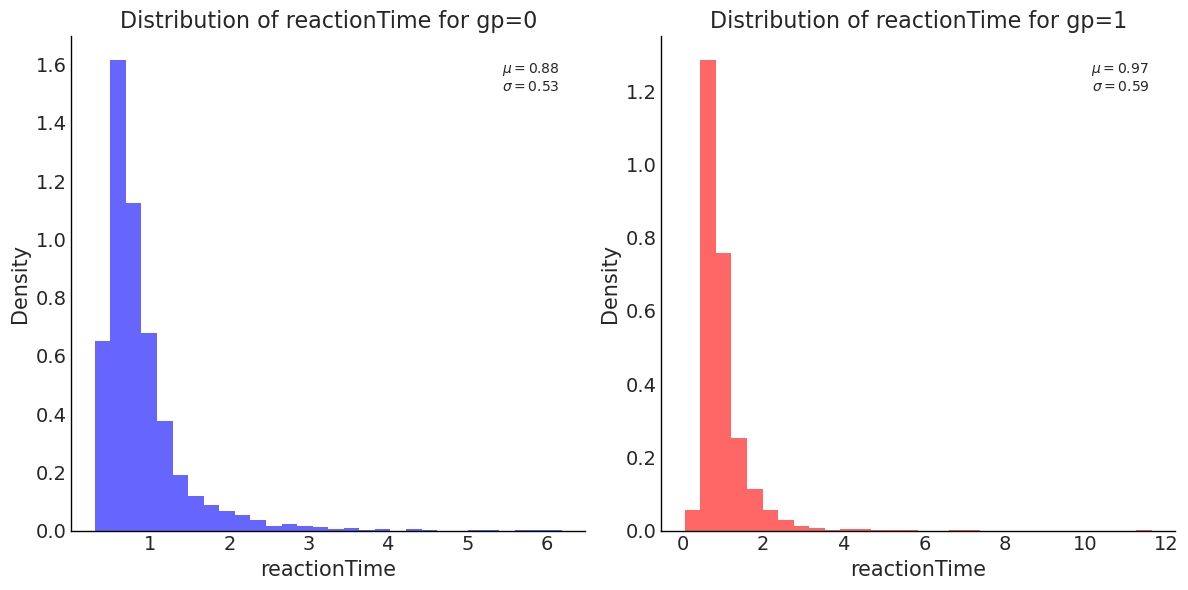

In [77]:
# 绘制 gp=0 和 gp=1 的 handError 分布
plt.figure(figsize=(12, 6))

# 创建两个子图
plt.subplot(1, 2, 1)
gp0_hand_errors = allTable[allTable['gp'] == 0]['reactionTime']
mu_gp0 = np.mean(gp0_hand_errors)
sigma_gp0 = np.std(gp0_hand_errors)
plt.hist(gp0_hand_errors, bins=30, density=True, alpha=0.6, color='b')
plt.title('Distribution of reactionTime for gp=0')
plt.xlabel('reactionTime')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp0:.2f}$\n$\sigma={sigma_gp0:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.subplot(1, 2, 2)
gp1_hand_errors = allTable[allTable['gp'] == 1]['reactionTime']
mu_gp1 = np.mean(gp1_hand_errors)
sigma_gp1 = np.std(gp1_hand_errors)
plt.hist(gp1_hand_errors, bins=30, density=True, alpha=0.6, color='r')
plt.title('Distribution of reactionTime for gp=1')
plt.xlabel('reactionTime')
plt.ylabel('Density')
plt.text(0.95, 0.95, f'$\mu={mu_gp1:.2f}$\n$\sigma={sigma_gp1:.2f}$', 
         transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

## model

In [78]:
var_names=['a0','aD','aE','aS','aES','aED']

numGroups = len(np.unique(allTable['gp']))
numS = len(np.unique(allTable['sIndex']))
numEps = len(np.unique(allTable['epIndex']))
numData = allTable.shape[0]

In [79]:
y = allTable.reactionTime.values # rt
e = allTable.epIndex.values.astype(int) # episode
d = allTable.gp.values.astype(int) # group
s = allTable.sIndex.values.astype(int) # subject

# find NaN and interpret
nan_indices = np.isnan(y)
interp_func = np.interp(nan_indices.nonzero()[0], (~nan_indices).nonzero()[0], y[~nan_indices])
y[nan_indices] = interp_func

# Define priors
muA0 = np.nanmean(y)
sdA0 = 10*np.nanstd(y)/np.sqrt(numData)
sdA0

0.07548969408642599

In [80]:
with pm.Model() as model4:
    # Hyper priors
    sdAS = pm.Gamma('sdAS', mu=0.5, sigma=1)
    sdAED = pm.Gamma('sdAED', mu=0.5, sigma=1)
    # Priors
    a0 = pm.Normal('a0', mu=muA0, sigma=sdA0)
    aE = pm.Normal('aE', mu=0.1, sigma=0.5, shape=numEps)
    aD = pm.Normal('aD', mu=0.1, sigma=0.5, shape=numGroups)
    aS = pm.Normal('aS', mu=0.1, sigma=sdAS, shape=numS)
    aED = pm.Normal('aED', mu=0.1, sigma=sdAED, shape=(numEps, numGroups)) 
    aES = pm.Normal('aES', mu=0.1, sigma=sdAS, shape=(numEps, numS)) 
    
    sdY = pm.HalfNormal('sdY', sigma=0.5, shape=numS)
    
    muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]
    
    y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y)

In [81]:
# with pm.Model() as model4:
#     # Hyper priors
#     sdAS = pm.Gamma('sdAS', mu=0.5, sigma=1)
    
#     # Priors
#     a0 = pm.HalfNormal('a0', sigma=sdA0)
#     aE = pm.HalfNormal('aE', sigma=0.5, shape=numEps)
#     aD = pm.HalfNormal('aD', sigma=0.5, shape=numGroups)
#     aS = pm.HalfNormal('aS', sigma=sdAS, shape=numS)
#     aED = pm.HalfNormal('aED', sigma=0.5, shape=(numEps, numGroups)) 
#     aES = pm.HalfNormal('aES', sigma=sdAS, shape=(numEps, numS)) 
    
#     sdY = pm.HalfNormal('sdY', sigma=0.5, shape=numS)
    
#     muY = a0 + aE[e] + aD[d] + aS[s] + aED[e,d] + aES[e,s]

#     y_obs = pm.Normal('y_obs', mu=muY, sigma=sdY[s], observed=y)

Sampling: [a0, aD, aE, aED, aES, aS, sdAED, sdAS, sdY, y_obs]


<Axes: xlabel='y_obs / y_obs'>

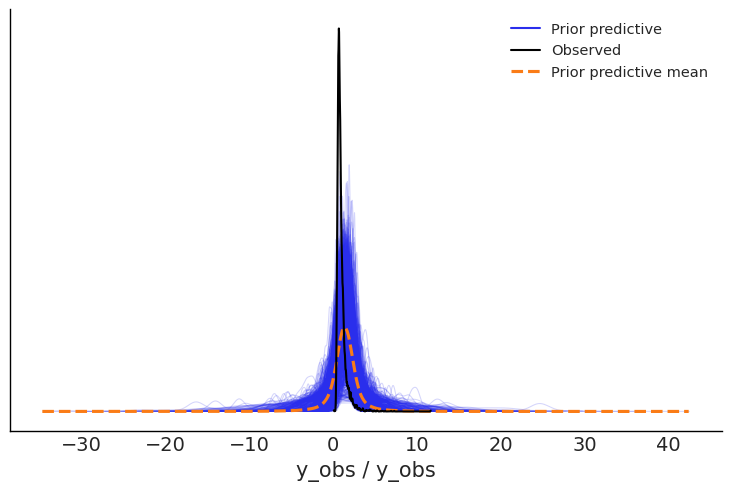

In [82]:
prior_checks4 = pm.sample_prior_predictive(samples=1000, model=model4)
az.plot_ppc(prior_checks4, observed=True, group="prior")

In [83]:
compiled_model4 = nutpie.compile_pymc_model(model4)

In [84]:
trace4 = nutpie.sample(compiled_model4, draws=1000, tune=1000, chains=4, target_accept=0.95)

Sampling: [y_obs]


<Axes: xlabel='y_obs / y_obs'>

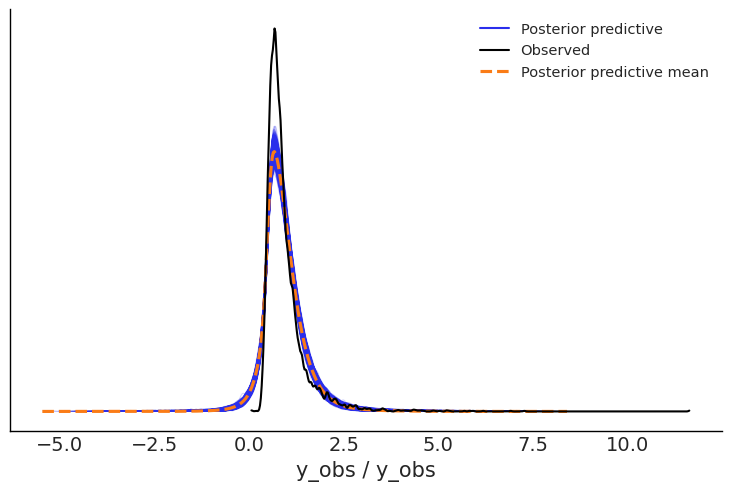

In [85]:
ppc4 = pm.sample_posterior_predictive(trace4, model=model4)
az.plot_ppc(ppc4, mean=True)

In [86]:
az.summary(trace4, round_to=2, var_names=['a0', 'aD'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a0,0.90,0.07,0.76,1.03,0.01,0.01,29.61,62.39,1.11
aD[0],-0.36,0.09,-0.55,-0.19,0.01,0.01,49.28,101.72,1.06
aD[1],-0.26,0.09,-0.45,-0.10,0.01,0.01,53.13,83.88,1.05


## calc

In [87]:
numChains = 4
numSamples = 1000
subjPerGroup = np.bincount(subjectTable['delay']-1)

# extract and define all episodes from samples
earlyBaseEps = [1]
epIndexesEarlyBase = np.where(np.isin(allEpisodes, earlyBaseEps))[0]
numEarlyBaseEps = len(earlyBaseEps)
earlyBaseSamplesEp = np.zeros((numChains * numSamples, numEarlyBaseEps))

lateBaseEps = [2]
epIndexesLateBase = np.where(np.isin(allEpisodes, lateBaseEps))[0]
numLateBaseEps = len(lateBaseEps)
lateBaseSamplesEp = np.zeros((numChains * numSamples, numLateBaseEps))

adaptEps = np.arange(100, 180)
epIndexesAdapt = np.where(np.isin(allEpisodes, adaptEps))[0]
numAdaptEps = len(adaptEps)
adaptSamplesEp = np.zeros((numChains * numSamples, numAdaptEps))

implicitEps = [200]
epIndexesImplicit = np.where(np.isin(allEpisodes, implicitEps))[0]
numImplicitEps = len(implicitEps)
implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))

afterEps = [300]
epIndexesAfter = np.where(np.isin(allEpisodes, afterEps))[0]
numAfterEps = len(afterEps)
afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))

In [88]:
# initialize
earlyBaseMeansAll = np.full((numGroups, 1), np.nan)
earlyBaseHDIAll = [None] * numGroups
lateBaseMeansAll = np.full((numGroups, 1), np.nan)
lateBaseHDIAll = [None] * numGroups

implicitMeansAll = np.full((numGroups, 1), np.nan)
implicitHDIAll = [None] * numGroups
implicitHDI = np.full((numGroups, 2), np.nan)
implicitSamples = [None] * numGroups

afterMeansAll = np.full((numGroups, 1), np.nan)
afterHDIAll = [None] * numGroups
afterHDI = np.full((numGroups, 2), np.nan)
afterSamples = [None] * numGroups

adaptMeansAll = [None] * numGroups
adaptHDIAll = [None] * numGroups
adaptHDI = np.zeros((numGroups, numAdaptEps, 2))
adaptSubjSamples = [[] for _ in range(numGroups)]
adaptSubjHDI = [[] for _ in range(numGroups)]

earlyBaseHDI = np.full((numGroups, 2), np.nan)
lateBaseHDI = np.full((numGroups, 2), np.nan)

earlyBaseSubjMeans = [[] for _ in range(numGroups)]
earlyBaseSubjHDI = [[] for _ in range(numGroups)]
lateBaseSubjMeans = [[] for _ in range(numGroups)]
lateBaseSubjHDI = [[] for _ in range(numGroups)]

lastAdaptSubjMeans = [[] for _ in range(numGroups)]
lastAdaptSubjHDI = [[] for _ in range(numGroups)]
lastAdaptSubjSamples = [[] for _ in range(numGroups)]

implicitSubjMeans = [[] for _ in range(numGroups)]
implicitSubjHDI = [[] for _ in range(numGroups)]
implicitSubjSamples = [[] for _ in range(numGroups)]

afterSubjMeans = [[] for _ in range(numGroups)]
afterSubjHDI = [[] for _ in range(numGroups)]
afterSubjSamples = [[] for _ in range(numGroups)]

mEpGpS = [None] * numGroups
mS = [None] * numGroups
mGp = np.zeros((numChains, numSamples, numGroups))
mEpGp = np.zeros((numChains, numSamples, numEps, numGroups))

In [89]:
b0 = trace4.posterior['a0']
bD = trace4.posterior['aD']
bS = trace4.posterior['aS']
bE = trace4.posterior['aE']
bED = trace4.posterior['aED']
bES = trace4.posterior['aES']

In [90]:
for gpNum in range(1,numGroups+1):
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    thisNumS = theseS.shape[0]
    mEpGpS[gpNum - 1] = np.zeros((numChains, numSamples, numEps, thisNumS))
    mS[gpNum - 1] = np.zeros((numChains, numSamples, thisNumS))
    
    for epNum in range(1,numEps+1):      
        for sNum in range(1,subjPerGroup[gpNum-1]+1):
            sIndex = theseS.loc[theseS.index == sNum-1, 'subjectST'].values[0]
            mEpGpS[gpNum-1][:,:,epNum-1, sNum-1] = (
                b0 + 
                bE[:, :, epNum-1] + 
                bD[:, :, gpNum-1] + 
                bS[:, :, sIndex-1]+ 
                bED[:, :, epNum-1, gpNum-1] + 
                bES[:, :, epNum-1, sIndex-1]
            )
        
        mEpGp[:, :, epNum-1, gpNum-1] = np.nanmean(mEpGpS[gpNum-1][:, :, epNum-1, :], axis=2)
    
    mS[gpNum - 1] = np.reshape(np.nanmean(mEpGpS[gpNum - 1], axis=2), (numChains, numSamples, subjPerGroup[gpNum - 1]))
    mGp[:, :, gpNum-1] = np.mean(mS[gpNum-1], axis=2)

mEp = np.nanmean(mEpGp, axis=3)
m = np.mean(mGp, axis=2)

# Correct for mean shift of groups
b0 = m
bE = mEp - np.tile(m[:, :, np.newaxis], (1, 1, numEps))
bD = mGp - np.tile(m[:, :, np.newaxis], (1, 1, numGroups))
bED = mEpGp - np.tile(mEp[:, :, :, np.newaxis], (1, 1, 1, numGroups))
- np.tile(np.reshape(mGp, (numChains, numSamples, 1, numGroups)), (1, 1, numEps, 1)) 
+ np.tile(m[:, :, np.newaxis, np.newaxis], (1, 1, numEps, numGroups))

for sIndex in range(1,numS+1):
    gpNum = subjectTable.loc[sIndex - 1, 'delay']  # gpNum=1 or 2
    theseS = subjectTable[subjectTable['delay'] == gpNum].reset_index(drop=True)
    sNum = theseS.index[theseS['subjectST'] == sIndex][0]
    bS[:, :, sIndex-1] = mS[gpNum-1][:, :, sNum] - mGp[:, :, gpNum-1]
    
    bES[:, :, :, sIndex-1] = (
    mEpGpS[gpNum-1][:, :, :, sNum] - 
    (np.tile(bS.values[:, :, sIndex-1, np.newaxis], (1, 1, numEps)) + mEpGp[:, :, :, gpNum-1])
    )

In [91]:
# Create a dictionary to hold the variables
samples4 = {
    'b0': b0,
    'bD': bD,
    'bS': bS,
    'bE': bE,
    'bED': bED,
    'bES': bES,
    'mAll': m,
    'mSubj': mS,
    'mdelay': mGp,
    'mEp': mEp,
    'mEpGp': mEpGp,
    'mEpGpS': mEpGpS
}

In [92]:
# Getting all the samples for the earlybaseline, latebaseline, implicit, aftereffect
for gpNum in range(numGroups):
    for epNum in range(numEarlyBaseEps):
        theseSamples = (
            samples4['b0'] + samples4['bE'][:, :, epIndexesEarlyBase[epNum]]
            + samples4['bD'][:, :, gpNum] + samples4['bED'][:, :, epIndexesEarlyBase[epNum], gpNum]
        )
        earlyBaseSamplesEp[:, epNum] = theseSamples.flatten()
            
        theseSamples = (
            samples4['b0'] + samples4['bE'][:, :, epIndexesLateBase[epNum]]
            + samples4['bD'][:, :, gpNum] + samples4['bED'][:, :, epIndexesLateBase[epNum], gpNum]
        )
        lateBaseSamplesEp[:, epNum] = theseSamples.flatten()
 
        theseSamples = (
            samples4['b0'] + samples4['bE'][:, :, epIndexesImplicit[epNum]]
            + samples4['bD'][:, :, gpNum] + samples4['bED'][:, :, epIndexesImplicit[epNum], gpNum]
        )
        implicitSamplesEp = np.zeros((numChains * numSamples, numImplicitEps))
        implicitSamplesEp[:, epNum] = theseSamples.flatten()
        
        theseSamples = (
            samples4['b0'] + samples4['bE'][:, :, epIndexesAfter[epNum]]
            + samples4['bD'][:, :, gpNum] + samples4['bED'][:, :, epIndexesAfter[epNum], gpNum]
        )
        afterSamplesEp = np.zeros((numChains * numSamples, numAfterEps))
        afterSamplesEp[:, epNum] = theseSamples.flatten()
            
    earlyBaseMeansAll[gpNum] = np.mean(earlyBaseSamplesEp)
    earlyBaseHDIAll[gpNum] = az.hdi(earlyBaseSamplesEp, hdi_prob=0.95)
    lateBaseMeansAll[gpNum] = np.mean(lateBaseSamplesEp)
    lateBaseHDIAll[gpNum] = az.hdi(lateBaseSamplesEp, hdi_prob=0.95)
    implicitMeansAll[gpNum] = np.mean(implicitSamplesEp)
    implicitHDIAll[gpNum] = az.hdi(implicitSamplesEp, hdi_prob=0.95)    
    afterMeansAll[gpNum] = np.mean(afterSamplesEp)
    afterHDIAll[gpNum] = az.hdi(afterSamplesEp, hdi_prob=0.95)
    # Save aftereffect samples so we can calculate differences between groups
    implicitSamples[gpNum] = implicitSamplesEp
    afterSamples[gpNum] = afterSamplesEp
    # HDI for use in errorbar function
    earlyBaseHDI[gpNum, 0] = earlyBaseHDIAll[gpNum][0][0] - earlyBaseMeansAll[gpNum][0]
    earlyBaseHDI[gpNum, 1] = earlyBaseMeansAll[gpNum][0] - earlyBaseHDIAll[gpNum][0][1]
    lateBaseHDI[gpNum, 0] = lateBaseHDIAll[gpNum][0][0] - lateBaseMeansAll[gpNum][0]
    lateBaseHDI[gpNum, 1] = lateBaseMeansAll[gpNum][0] - lateBaseHDIAll[gpNum][0][1]
    implicitHDI[gpNum, 0] = implicitHDIAll[gpNum][0][0] - implicitMeansAll[gpNum][0]
    implicitHDI[gpNum, 1] = implicitMeansAll[gpNum][0] - implicitHDIAll[gpNum][0][1]
    afterHDI[gpNum, 0] = afterHDIAll[gpNum][0][0] - afterMeansAll[gpNum][0]
    afterHDI[gpNum, 1] = afterMeansAll[gpNum][0] - afterHDIAll[gpNum][0][1]
               
    ## per subject
    gpS = np.where(subjectTable['delay'] == (gpNum+1))[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesEarlyBase = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesLateBase = np.zeros((numChains * numSamples, numAfterEps))
        theseSamplesImplicit = np.zeros((numChains * numSamples, numImplicitEps))
        theseSamplesAfter = np.zeros((numChains * numSamples, numAfterEps))
        for epNum in range(numAfterEps):
            thisSubjSamples = samples4['bS'][:, :, gpS[sNum]] + samples4['bES'][:, :, epIndexesEarlyBase[epNum], gpS[sNum]]
            theseSamplesEarlyBase[:, epNum] = earlyBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
                
            thisSubjSamples = samples4['bS'][:, :, gpS[sNum]] + samples4['bES'][:, :, epIndexesLateBase[epNum], gpS[sNum]]
            theseSamplesLateBase[:, epNum] = lateBaseSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
 
            thisSubjSamples = samples4['bS'][:, :, gpS[sNum]] + samples4['bES'][:, :, epIndexesImplicit[epNum], gpS[sNum]]
            theseSamplesImplicit[:, epNum] = implicitSamplesEp[:, epNum] + thisSubjSamples.values.flatten()
        
            thisSubjSamples = samples4['bS'][:, :, gpS[sNum]] + samples4['bES'][:, :, epIndexesAfter[epNum], gpS[sNum]]
            theseSamplesAfter[:, epNum] = afterSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        earlyBaseSubjMeans[gpNum].append(np.mean(theseSamplesEarlyBase, axis=0))
        earlyBaseSubjHDI[gpNum].append(az.hdi(theseSamplesEarlyBase, hdi_prob=0.95))
        lateBaseSubjMeans[gpNum].append(np.mean(theseSamplesLateBase, axis=0))
        lateBaseSubjHDI[gpNum].append(az.hdi(theseSamplesLateBase, hdi_prob=0.95))
        implicitSubjMeans[gpNum].append(np.mean(theseSamplesImplicit, axis=0))
        implicitSubjHDI[gpNum].append(az.hdi(theseSamplesImplicit, hdi_prob=0.95))
        afterSubjMeans[gpNum].append(np.mean(theseSamplesAfter, axis=0))
        afterSubjHDI[gpNum].append(az.hdi(theseSamplesAfter, hdi_prob=0.95))
        # Save aftereffect samples to calculate differences
        implicitSubjSamples[gpNum].append(theseSamplesImplicit)
        afterSubjSamples[gpNum].append(theseSamplesAfter)
        

# Now the adaptation episodes
for gpNum in range(numGroups):
    for epNum in range(numAdaptEps):
        theseSamples = (
            samples4['b0'] + samples4['bE'][:, :, epIndexesAdapt[epNum]]
            + samples4['bD'][:, :, gpNum] + samples4['bED'][:, :, epIndexesAdapt[epNum], gpNum]
        )
        adaptSamplesEp[:, epNum] = theseSamples.flatten()

    adaptMeansAll[gpNum] = np.mean(adaptSamplesEp, axis=0)
    adaptHDIAll[gpNum] = az.hdi(adaptSamplesEp, hdi_prob=0.95)
    adaptHDI[gpNum, :, 0] = adaptHDIAll[gpNum][:,0] - adaptMeansAll[gpNum]
    adaptHDI[gpNum, :, 1] = adaptMeansAll[gpNum] - adaptHDIAll[gpNum][:,1]
    
    # Per subject
    gpS = np.where(subjectTable['delay'] == gpNum+1)[0]
    numS = len(gpS)
    for sNum in range(numS):
        theseSamplesAdapt = np.zeros((numChains * numSamples, numAdaptEps))
        for epNum in range(numAdaptEps):
            thisSubjSamples = (
                samples4['bS'][:, :, gpS[sNum]] + samples4['bES'][:, :, epIndexesAdapt[epNum], gpS[sNum]]
            )
            theseSamplesAdapt[:, epNum] = adaptSamplesEp[:, epNum] + thisSubjSamples.values.flatten()

        theseLastAdaptSamples = theseSamplesAdapt[:, 40:80]
        lastAdaptSubjMeans[gpNum].append(np.mean(theseLastAdaptSamples, axis=0))
        lastAdaptSubjHDI[gpNum].append(az.hdi(theseLastAdaptSamples, hdi_prob=0.95))
        adaptSubjHDI[gpNum].append(az.hdi(theseSamplesAdapt, hdi_prob=0.95))
        # Save adaptation subject samples to calculate implicit differences
        lastAdaptSubjSamples[gpNum].append(theseLastAdaptSamples)
        adaptSubjSamples[gpNum].append(theseSamplesAdapt)
        
        
sortedEpsRt = {
        'earlyBaseMeansAll': earlyBaseMeansAll,
        'earlyBaseHDIAll': earlyBaseHDIAll,
        'lateBaseMeansAll': lateBaseMeansAll,
        'lateBaseHDIAll': lateBaseHDIAll,
        'implicitMeansAll': implicitMeansAll,
        'implicitHDIAll': implicitHDIAll,
        'implicitSamples': implicitSamples,    
        'afterMeansAll': afterMeansAll,
        'afterHDIAll': afterHDIAll,
        'afterSamples': afterSamples,
        'earlyBaseHDI': earlyBaseHDI,
        'lateBaseHDI': lateBaseHDI,
        'implicitHDI': implicitHDI,
        'afterHDI': afterHDI,
        'earlyBaseSubjMeans': earlyBaseSubjMeans,
        'earlyBaseSubjHDI': earlyBaseSubjHDI,
        'lateBaseSubjMeans': lateBaseSubjMeans,
        'lateBaseSubjHDI': lateBaseSubjHDI,
        'implicitSubjMeans': implicitSubjMeans,
        'implicitSubjHDI': implicitSubjHDI,
        'implicitSubjSamples': implicitSubjSamples,
        'afterSubjMeans': afterSubjMeans,
        'afterSubjHDI': afterSubjHDI,
        'afterSubjSamples': afterSubjSamples,
        'adaptMeansAll': adaptMeansAll,
        'adaptHDIAll': adaptHDIAll,
        'adaptHDI': adaptHDI,
        'adaptSubjSamples': adaptSubjSamples,
        'adaptSubjHDI': adaptSubjHDI,
        'lastAdaptSubjMeans': lastAdaptSubjMeans,
        'lastAdaptSubjHDI': lastAdaptSubjHDI,
        'lastAdaptSubjSamples': lastAdaptSubjSamples,
    }

## plot

In [93]:
handColors = ['blue', 'brown']
eyeColors = ['darkgreen', 'chocolate']

In [94]:
# get mean of all subjects across all trials
# 按trialNum和gp分组，计算errorCorrect均值
mean_rt = allTable.groupby(['trialNum', 'gp'])['reactionTime'].mean().reset_index()

# 分别获取gp为0和gp为1时的均值
gp0_mean_rt = mean_rt[mean_rt['gp'] == 0]
gp1_mean_rt = mean_rt[mean_rt['gp'] == 1]

[Text(25, 0, '25'),
 Text(50, 0, '50'),
 Text(90, 0, '90'),
 Text(130, 0, '130'),
 Text(150, 0, '150')]

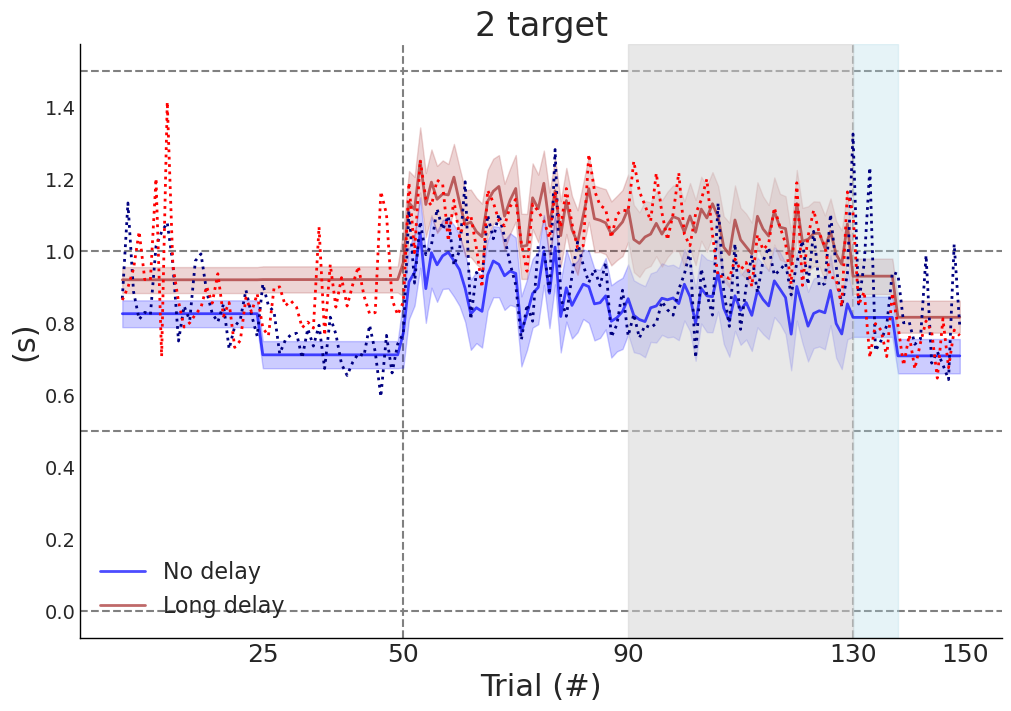

In [97]:
# 合并时间段数据
x_full = np.concatenate((np.arange(0, 25), np.arange(25, 50), np.arange(50, 130), np.arange(130, 138), np.arange(138, 150)))
y_full_gp0 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseMeansAll'][0], dtype=float),
                             np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseMeansAll'][0], dtype=float),
                             sortedEpsRt['adaptMeansAll'][0],
                             np.full_like(np.arange(130, 138), sortedEpsRt['implicitMeansAll'][0][0], dtype=float),
                             np.full_like(np.arange(138, 150), sortedEpsRt['afterMeansAll'][0][0], dtype=float)))
y_full_gp1 = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseMeansAll'][1], dtype=float),
                             np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseMeansAll'][1], dtype=float),
                             sortedEpsRt['adaptMeansAll'][1],
                             np.full_like(np.arange(130, 138), sortedEpsRt['implicitMeansAll'][1][0], dtype=float),
                             np.full_like(np.arange(138, 150), sortedEpsRt['afterMeansAll'][1][0], dtype=float)))

# 合并HDI数据
hdi_full_gp0_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseHDIAll'][0][0, 0], dtype=float),
                                   np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseHDIAll'][0][0, 0], dtype=float),
                                   sortedEpsRt['adaptHDIAll'][0][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsRt['implicitHDIAll'][0][0, 0], dtype=float),
                                   np.full_like(np.arange(138, 150), sortedEpsRt['afterHDIAll'][0][0, 0], dtype=float)))
hdi_full_gp0_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseHDIAll'][0][0, 1], dtype=float),
                                    np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseHDIAll'][0][0, 1], dtype=float),
                                    sortedEpsRt['adaptHDIAll'][0][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsRt['implicitHDIAll'][0][0, 1], dtype=float),
                                    np.full_like(np.arange(138, 150), sortedEpsRt['afterHDIAll'][0][0, 1], dtype=float)))
hdi_full_gp1_low = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseHDIAll'][1][0, 0], dtype=float),
                                   np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseHDIAll'][1][0, 0], dtype=float),
                                   sortedEpsRt['adaptHDIAll'][1][:, 0],
                                   np.full_like(np.arange(130, 138), sortedEpsRt['implicitHDIAll'][1][0, 0], dtype=float),
                                   np.full_like(np.arange(138, 150), sortedEpsRt['afterHDIAll'][1][0, 0], dtype=float)))
hdi_full_gp1_high = np.concatenate((np.full_like(np.arange(0, 25), sortedEpsRt['earlyBaseHDIAll'][1][0, 1], dtype=float),
                                    np.full_like(np.arange(25, 50), sortedEpsRt['lateBaseHDIAll'][1][0, 1], dtype=float),
                                    sortedEpsRt['adaptHDIAll'][1][:, 1],
                                    np.full_like(np.arange(130, 138), sortedEpsRt['implicitHDIAll'][1][0, 1], dtype=float),
                                    np.full_like(np.arange(138, 150), sortedEpsRt['afterHDIAll'][1][0, 1], dtype=float)))

# 画图
fig, ax = plt.subplots(figsize=(10, 7))

# 绘制合并后的数据
model_mean_gp0 = ax.plot(x_full, y_full_gp0, color=handColors[0], linewidth=2, label='model mean (no delay)', zorder=2, alpha=0.7)
model_mean_gp1 = ax.plot(x_full, y_full_gp1, color=handColors[1], linewidth=2, label='model mean (long delay)', zorder=2, alpha=0.7)
# 绘制HDI区域
hdi_gp0 = ax.fill_between(x_full, hdi_full_gp0_low, hdi_full_gp0_high, color=handColors[0], alpha=0.2, zorder=1)
hdi_gp1 = ax.fill_between(x_full, hdi_full_gp1_low, hdi_full_gp1_high, color=handColors[1], alpha=0.2, zorder=1)
# 绘制mean data
mean_gp0 = ax.plot(x_full, gp0_mean_rt['reactionTime'], color='navy', linewidth=2, linestyle=':', zorder=3, alpha=1)
mean_gp1 = ax.plot(x_full, gp1_mean_rt['reactionTime'], color='red', linewidth=2, linestyle=':', zorder=3, alpha=1)

# 绘制不同阶段的背景色
implicit_patch = patches.Patch(color='lightblue', alpha=0.3, label='Implicit Measurement')
ax.axvspan(130, 138, color='lightblue', alpha=0.3)  # implicit
eye_explicit_patch = patches.Patch(color='lightgrey', alpha=0.5, label='Eye Explicit Measurement')
ax.axvspan(90, 130, color='lightgrey', alpha=0.5)  # eye explicit

# ax.legend([model_mean_gp0[0], model_mean_gp1[0], hdi_gp0, hdi_gp1, mean_gp0[0], mean_gp1[0]], 
#           ['model mean (no delay)', 'model mean (long delay)', 'HDI (no delay)', 'HDI (long delay)', 'mean (no delay)', 'mean (long delay)']
#           , fontsize=16,loc='upper right')
ax.legend([model_mean_gp0[0], model_mean_gp1[0]], 
          ['No delay', 'Long delay']
          , fontsize=16,loc='best')

ax.set_title('2 target',fontsize=24)
ax.set_ylabel('(s)',fontsize=22)
ax.set_xlabel('Trial (#)',fontsize=22)
ax.axhline(0, linestyle='--', color='grey', zorder=0)
ax.axhline(0.5, linestyle='--', color='grey', zorder=0)
ax.axhline(1, linestyle='--', color='grey', zorder=0)
ax.axhline(1.5, linestyle='--', color='grey', zorder=0)
ax.axvline(50, linestyle='--', color='grey', zorder=0)
ax.axvline(130, linestyle='--', color='grey', zorder=0)

ax.set_xticks([25, 50, 90, 130, 150])
ax.set_xticklabels([25, 50, 90, 130, 150],fontsize=18)  
# ax.set_yticks(np.arange(0, 2, 0.5))
# ax.set_yticklabels(np.arange(0, 2, 0.5),fontsize=18)
# ax.set_ylim(0, 2.1)
# ax.set_xlim(0, 150) 

In [98]:
# # save data 
# if SaveAllData == 1:
#     file_path = 'sortedEpsRt_2T.pkl'

#     print('data saved')
#     with open(file_path, 'wb') as f:
#         pickle.dump(sortedEpsRt, f)

In [99]:
mean_gp0_rt = np.nanmean(sortedEpsRt['lastAdaptSubjMeans'][0])
mean_gp0_rt

0.8500409310582262

In [100]:
az.hdi(np.mean(sortedEpsRt['lastAdaptSubjSamples'][0], axis=(0,2)), hdi_prob=0.95)

array([0.81902047, 0.88194036])

In [101]:
mean_gp1_rt = np.nanmean(sortedEpsRt['lastAdaptSubjMeans'][1])
mean_gp1_rt

1.0534231242763967

In [102]:
az.hdi(np.mean(sortedEpsRt['lastAdaptSubjSamples'][1], axis=(0,2)), hdi_prob=0.95)

array([1.02173144, 1.08345406])